# 

In [ ]:
# Required pip installations:
!pip3 install osmnx networkx numpy matplotlib pandas openpyxl scikit-learn

In [92]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import time
import heapq
import subprocess
import platform
from matplotlib.lines import Line2D
from IPython.display import display, clear_output

In [93]:
# Set a seed for reproducibility
np.random.seed(42)

In [94]:
# Configure OSMnx settings
ox.settings.use_cache = True
ox.settings.log_console = True
ox.settings.all_oneway = True

In [95]:
# Create output directories
output_dir = 'london_simulation'
excel_dir = os.path.join(output_dir, 'excel_data')
maps_dir = os.path.join(output_dir, 'scenario_maps')

os.makedirs(output_dir, exist_ok=True)
os.makedirs(excel_dir, exist_ok=True)
os.makedirs(maps_dir, exist_ok=True)

In [96]:
def load_london_network():
    """Load and return the London street network"""
    print("Loading London street network...")
    
    # Define the London area - using City of London for a smaller, manageable area
    place_name = "City of London, UK"
    G = ox.graph_from_place(place_name, network_type='drive', simplify=False)
    
    # Check if the network is connected
    is_connected = nx.is_strongly_connected(G)
    if not is_connected:
        print("Extracting largest strongly connected component...")
        largest_component = max(nx.strongly_connected_components(G), key=len)
        G = G.subgraph(largest_component).copy()
    
    print(f"Network loaded with {len(G.nodes)} nodes and {len(G.edges)} edges")
    return G

In [97]:
class Vehicle:
    def __init__(self, id, source, destination, path=None):
        self.id = id
        self.source = source
        self.destination = destination
        self.path = path  # Default path (calculated with A*)
        self.paths = {}   # Dictionary to store paths calculated by different algorithms
        self.travel_times = {}  # Dictionary to store travel times by algorithm
        self.computation_times = {}  # Dictionary to store computation times
        self.service_rates = {}  # Dictionary to store service rates by algorithm ← NEW
        self.current_position = 0  # Position in the path
        self.completed = False
        self.selected_for_analysis = False  # Flag to mark vehicles for analysis

    def __str__(self):
        return f"Vehicle {self.id}: {self.source} -> {self.destination} (Paths: {len(self.paths)})"

def generate_initial_congestion(G):
    print("Generating initial congestion data...")
    congestion_data = {}
    
    for u, v, k in G.edges(keys=True):
        # Generate random congestion value between 2.0 and 10.0 for Normal scenario
        congestion = 2.0 + 8.0 * np.random.random()
        
        # Store congestion value
        edge_id = f"{u}_{v}_{k}"
        congestion_data[edge_id] = congestion
        
        # Add congestion attribute to the edge in the graph
        G[u][v][k]['congestion'] = congestion
        
        # Initialize vehicle count on each edge
        G[u][v][k]['vehicle_count'] = 0
    
    return congestion_data

def calculate_congestion_stats(congestion_data):
    congestion_values = list(congestion_data.values())
    return {
        "mean": np.mean(congestion_values),
        "median": np.median(congestion_values),
        "min": np.min(congestion_values),
        "max": np.max(congestion_values),
        "std": np.std(congestion_values)
    }
def enhanced_a_star_algorithm(G, start, end):
    """Enhanced A* algorithm using direct distance as heuristic and better congestion handling"""
    start_time = time.time()
    
    # Get node positions for heuristic
    pos = {}
    for node in G.nodes():
        if 'x' in G.nodes[node] and 'y' in G.nodes[node]:
            pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])
        else:
            # If no coordinates, use topology distance
            pos[node] = (0, 0)
    
    # Define heuristic function (Euclidean distance)
    def heuristic(n1, n2):
        if n1 in pos and n2 in pos:
            x1, y1 = pos[n1]
            x2, y2 = pos[n2]
            return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
        else:
            return 0
    
    # Initialize data structures
    g_score = {node: float('infinity') for node in G.nodes()}
    g_score[start] = 0
    
    f_score = {node: float('infinity') for node in G.nodes()}
    f_score[start] = heuristic(start, end)
    
    # Track previous nodes for path reconstruction
    previous = {node: None for node in G.nodes()}
    
    # Priority queue for nodes to visit (f_score, node)
    open_set = [(f_score[start], start)]
    closed_set = set()
    
    while open_set:
        # Get node with smallest f_score
        _, current_node = heapq.heappop(open_set)
        
        # If we've reached the end, we're done
        if current_node == end:
            break
        
        # Skip if already processed
        if current_node in closed_set:
            continue
            
        closed_set.add(current_node)
        
        # Check all neighbors
        for neighbor in G.neighbors(current_node):
            if neighbor in closed_set:
                continue
                
            # Calculate travel time with congestion penalty
            travel_time = G[current_node][neighbor]['travel_time']
            congestion = G[current_node][neighbor].get('congestion', 1.0)
            
            # Apply additional penalty for high congestion
            if congestion > 8.0:  # Near max congestion
                # Severely penalize edges with very high congestion
                penalty = travel_time * 3.0  # Triple the travel time
            elif congestion > 6.0:  # High congestion
                # Significant penalty
                penalty = travel_time * 2.0  # Double the travel time
            elif congestion > 4.0:  # Medium congestion
                # Moderate penalty
                penalty = travel_time * 1.5  # 50% more travel time
            else:
                # Low congestion, just use the travel time
                penalty = travel_time
            
            # Calculate new g_score
            tentative_g_score = g_score[current_node] + penalty
            
            # Update if this is a better path
            if tentative_g_score < g_score[neighbor]:
                previous[neighbor] = current_node
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, end)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
    
    # Reconstruct path
    if g_score[end] == float('infinity'):
        print(f"No path found from {start} to {end} using Enhanced A* algorithm")
        return None, float('inf'), 0
    
    path = []
    current = end
    while current:
        path.append(current)
        current = previous[current]
    path.reverse()
    
    # Calculate actual path length based on travel time (without penalties)
    path_length = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        path_length += G[u][v]['travel_time']
    
    end_time = time.time()
    computation_time = end_time - start_time
    
    return path, path_length, computation_time
def enhanced_a_star_algorithm(G, start, end):
    """Enhanced A* algorithm using direct distance as heuristic and better congestion handling"""
    start_time = time.time()
    
    # Get node positions for heuristic
    pos = {}
    for node in G.nodes():
        if 'x' in G.nodes[node] and 'y' in G.nodes[node]:
            pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])
        else:
            # If no coordinates, use topology distance
            pos[node] = (0, 0)
    
    # Define heuristic function (Euclidean distance)
    def heuristic(n1, n2):
        if n1 in pos and n2 in pos:
            x1, y1 = pos[n1]
            x2, y2 = pos[n2]
            return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
        else:
            return 0
    
    # Initialize data structures
    g_score = {node: float('infinity') for node in G.nodes()}
    g_score[start] = 0
    
    f_score = {node: float('infinity') for node in G.nodes()}
    f_score[start] = heuristic(start, end)
    
    # Track previous nodes for path reconstruction
    previous = {node: None for node in G.nodes()}
    
    # Priority queue for nodes to visit (f_score, node)
    open_set = [(f_score[start], start)]
    closed_set = set()
    
    while open_set:
        # Get node with smallest f_score
        _, current_node = heapq.heappop(open_set)
        
        # If we've reached the end, we're done
        if current_node == end:
            break
        
        # Skip if already processed
        if current_node in closed_set:
            continue
            
        closed_set.add(current_node)
        
        # Check all neighbors
        for neighbor in G.neighbors(current_node):
            if neighbor in closed_set:
                continue
                
            # Calculate travel time with congestion penalty
            travel_time = G[current_node][neighbor]['travel_time']
            congestion = G[current_node][neighbor].get('congestion', 1.0)
            
            # Apply additional penalty for high congestion
            if congestion > 8.0:  # Near max congestion
                # Severely penalize edges with very high congestion
                penalty = travel_time * 3.0  # Triple the travel time
            elif congestion > 6.0:  # High congestion
                # Significant penalty
                penalty = travel_time * 2.0  # Double the travel time
            elif congestion > 4.0:  # Medium congestion
                # Moderate penalty
                penalty = travel_time * 1.5  # 50% more travel time
            else:
                # Low congestion, just use the travel time
                penalty = travel_time
            
            # Calculate new g_score
            tentative_g_score = g_score[current_node] + penalty
            
            # Update if this is a better path
            if tentative_g_score < g_score[neighbor]:
                previous[neighbor] = current_node
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, end)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
    
    # Reconstruct path
    if g_score[end] == float('infinity'):
        print(f"No path found from {start} to {end} using Enhanced A* algorithm")
        return None, float('inf'), 0
    
    path = []
    current = end
    while current:
        path.append(current)
        current = previous[current]
    path.reverse()
    
    # Calculate actual path length based on travel time (without penalties)
    path_length = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        path_length += G[u][v]['travel_time']
    
    end_time = time.time()
    computation_time = end_time - start_time
    
    return path, path_length, computation_time
def get_edge_travel_time(G, u, v, default=60.0):
    """
    UTILITY FUNCTION: Robust method to get travel time from any graph structure
    """
    try:
        # Method 1: Direct edge access with multiple keys
        if u in G and v in G[u]:
            edge_dict = G[u][v]
            
            if isinstance(edge_dict, dict):
                # Multi-edge graph - try each key
                for key in edge_dict.keys():
                    edge_data = edge_dict[key]
                    
                    if isinstance(edge_data, dict):
                        travel_time = edge_data.get('travel_time')
                        if travel_time is not None:
                            return float(travel_time)
                    elif isinstance(edge_data, (int, float)):
                        return float(edge_data)
            elif isinstance(edge_dict, (int, float)):
                return float(edge_dict)
        
        # Method 2: NetworkX edges access
        try:
            edges_data = G.edges[u, v]
            if isinstance(edges_data, dict):
                travel_time = edges_data.get('travel_time')
                if travel_time is not None:
                    return float(travel_time)
        except:
            pass
        
        # Method 3: Try with key=0 (common default)
        try:
            edge_data = G.edges[u, v, 0]
            if isinstance(edge_data, dict):
                travel_time = edge_data.get('travel_time')
                if travel_time is not None:
                    return float(travel_time)
        except:
            pass
        
        # Method 4: Use get_edge_data
        try:
            edge_data = G.get_edge_data(u, v)
            if isinstance(edge_data, dict):
                if len(edge_data) == 1:
                    # Single edge
                    key = list(edge_data.keys())[0]
                    data = edge_data[key]
                    if isinstance(data, dict):
                        travel_time = data.get('travel_time')
                        if travel_time is not None:
                            return float(travel_time)
        except:
            pass
            
    except Exception as e:
        pass
    
    # Return default if all methods fail
    return default


def get_edge_attribute(G, u, v, attribute, default):
    """
    UTILITY FUNCTION: Get any attribute from edge with fallbacks
    """
    try:
        if u in G and v in G[u]:
            edge_dict = G[u][v]
            if isinstance(edge_dict, dict):
                for key in edge_dict.keys():
                    edge_data = edge_dict[key]
                    if isinstance(edge_data, dict):
                        value = edge_data.get(attribute)
                        if value is not None:
                            return value
        
        # Try NetworkX edges access
        edge_data = G.edges[u, v, 0]
        if isinstance(edge_data, dict):
            value = edge_data.get(attribute)
            if value is not None:
                return value
                
    except:
        pass
    
    return default

def simple_algorithm_comparison_table(G, vehicle, congestion_data):
    """
    FALLBACK VERSION: Simple comparison when complex analysis fails
    """
    if not vehicle.paths:
        print("No paths calculated for this vehicle")
        return
    
    print(f"\nSimple Algorithm Comparison for Vehicle {vehicle.id}")
    print("=" * 60)
    
    results = []
    for algo_name, path in vehicle.paths.items():
        if not path:
            continue
            
        travel_time = vehicle.travel_times.get(algo_name, 0)
        comp_time = vehicle.computation_times.get(algo_name, 0)
        service_rate = vehicle.service_rates.get(algo_name, 0)
        
        results.append({
            'Algorithm': algo_name,
            'Path Length': len(path),
            'Travel Time/Distance': travel_time,
            'Computation Time': comp_time,
            'Service Rate': service_rate
        })
    
    df = pd.DataFrame(results)
    if not df.empty:
        print(df.to_string(index=False, float_format='%.4f'))
        best_service = df.loc[df['Service Rate'].idxmax(), 'Algorithm']
        print(f"\nHighest service rate: {best_service}")
        print(f"Note: A* optimizes for travel time, Greedy optimizes for distance")
    
    return df
def open_excel_file(file_path):
    if file_path and os.path.exists(file_path):
        try:
            if platform.system() == 'Darwin':       # macOS
                subprocess.call(('open', file_path))
            elif platform.system() == 'Windows':    # Windows
                os.startfile(file_path)
            else:                                   # Linux variants
                subprocess.call(('xdg-open', file_path))
            print(f"Opened Excel file: {file_path}")
        except Exception as e:
            print(f"Error opening Excel file: {e}")
    else:
        print("No Excel file available to open.")

In [98]:
def create_random_hotspots(center_x, center_y, max_dist, num_hotspots=3, radius_factor=0.2):
    """Create random congestion hotspots within the map"""
    hotspots = []
    
    for _ in range(num_hotspots):
        # Random angle and distance from center
        angle = np.random.uniform(0, 2 * np.pi)
        # Distribute hotspots across the map, but avoid the very edge
        distance = np.random.uniform(0.1, 0.9) * max_dist
        
        # Convert to cartesian coordinates
        x = center_x + distance * np.cos(angle)
        y = center_y + distance * np.sin(angle)
        
        # Random radius and intensity
        radius = np.random.uniform(0.1, 0.3) * max_dist * radius_factor
        intensity = np.random.uniform(0.7, 1.0)  # How strong the hotspot is
        
        hotspots.append((x, y, radius, intensity))
    
    return hotspots

def apply_consistent_congestion_scenario(G, congestion_data, scenario, base_congestion=None, special_case_type=None):
    print(f"\nApplying '{scenario}' congestion scenario...")
    G.graph["scenario_name"] = scenario
    G.graph["special_case_type"] = special_case_type
    
    # --- Determine reference baseline ---
    if base_congestion is not None:
        print("  Using provided 'base_congestion' as reference.")
        reference_congestion = base_congestion.copy()
    else:
        print("  WARNING: 'base_congestion' not provided.")
        if not congestion_data:
            raise ValueError("Cannot determine reference congestion.")
        reference_congestion = congestion_data.copy()
    
    # Create a new random seed based on current time to ensure patterns are different each run
    random_seed = int(time.time()) % (2**32)
    np.random.seed(random_seed)
    print(f"  Using random seed: {random_seed} for {scenario} scenario")
    
    # Get node positions for geographic-based congestion patterns
    node_positions = {}
    for node, data in G.nodes(data=True):
        if 'x' in data and 'y' in data:
            node_positions[node] = (data['x'], data['y'])
    
    # Find the center and bounds of the map
    if node_positions:
        coords = np.array(list(node_positions.values()))
        center_x, center_y = np.mean(coords, axis=0)
        min_x, min_y = np.min(coords, axis=0)
        max_x, max_y = np.max(coords, axis=0)
        max_dist = max(max_x - min_x, max_y - min_y) / 2
    else:
        center_x, center_y = 0, 0
        max_dist = 0.05
    
    # Create random hotspots for this scenario
    if scenario == "Morning":
        # Morning rush: 5-6 on average, with higher values at hotspots
        num_hotspots = np.random.randint(3, 6)  # 3-5 hotspots
        hotspots = create_random_hotspots(center_x, center_y, max_dist, num_hotspots)
        
    elif scenario == "Evening":
        # Evening rush: 7-9 on average, with higher values at hotspots
        num_hotspots = np.random.randint(4, 7)  # 4-6 hotspots
        hotspots = create_random_hotspots(center_x, center_y, max_dist, num_hotspots)
        
    elif scenario == "Weekend":
        # Weekend: 4-8 on average, with higher values at hotspots
        num_hotspots = np.random.randint(5, 9)  # 5-8 hotspots (more shopping/leisure areas)
        hotspots = create_random_hotspots(center_x, center_y, max_dist, num_hotspots)
        
    elif scenario == "Special":
        # Special Case: Totally random pattern
        num_hotspots = np.random.randint(1, 10)  # 1-9 hotspots
        hotspots = create_random_hotspots(center_x, center_y, max_dist, num_hotspots)
        
    else:  # Normal
        # Normal: Random congestion with some hotspots
        num_hotspots = np.random.randint(2, 5)  # 2-4 hotspots
        hotspots = create_random_hotspots(center_x, center_y, max_dist, num_hotspots)
    
    print(f"  Created {num_hotspots} random congestion hotspots")
    
    # Create a new congestion data dictionary
    scenario_result_congestion = {}
    edges_updated = 0
    
    for u, v, k in G.edges(keys=True):
        edge_id = f"{u}_{v}_{k}"
        
        # Get edge coordinates if available
        edge_x, edge_y = center_x, center_y  # Default to center
        if u in node_positions:
            u_x, u_y = node_positions[u]
            v_x, v_y = center_x, center_y  # Default
            if v in node_positions:
                v_x, v_y = node_positions[v]
            edge_x, edge_y = (u_x + v_x) / 2, (u_y + v_y) / 2
        
        # Calculate baseline congestion based on scenario
        if scenario == "Normal":
            # Normal: Random congestion from 2-10
            base_congestion = 2.0 + 8.0 * np.random.random()
            
        elif scenario == "Morning":
            # Morning Rush: Base congestion from 5-6
            base_congestion = 5.0 + np.random.random()
            
        elif scenario == "Evening":
            # Evening Rush: Base congestion from 7-9
            base_congestion = 7.0 + 2.0 * np.random.random()
            
        elif scenario == "Weekend":
            # Weekend: Base congestion from 4-8
            base_congestion = 4.0 + 4.0 * np.random.random()
            
        elif scenario == "Special":
            # Special Case: Fully random base congestion
            base_congestion = 1.0 + 9.0 * np.random.random()
            
        else:
            # Default fallback
            base_congestion = 5.0
        
        # Apply hotspot effects
        hotspot_effect = 0
        for hot_x, hot_y, radius, intensity in hotspots:
            # Calculate distance to hotspot
            dist = np.sqrt((edge_x - hot_x)**2 + (edge_y - hot_y)**2)
            
            # If within radius, apply effect with falloff
            if dist < radius:
                # Linear falloff from center of hotspot
                distance_factor = 1.0 - (dist / radius)
                
                # Calculate effect (higher for evening rush, lower for normal)
                if scenario == "Morning":
                    effect = distance_factor * intensity * 4.0  # Up to +4 at center
                elif scenario == "Evening":
                    effect = distance_factor * intensity * 3.0  # Up to +3 at center
                elif scenario == "Weekend":
                    effect = distance_factor * intensity * 5.0  # Up to +5 at center
                elif scenario == "Special":
                    effect = distance_factor * intensity * 7.0  # Up to +7 at center
                else:  # Normal
                    effect = distance_factor * intensity * 6.0  # Up to +6 at center
                
                hotspot_effect = max(hotspot_effect, effect)
        
        # Calculate final congestion - add hotspot effect
        new_congestion = base_congestion + hotspot_effect
        
        # Add some randomization to create more varied patterns
        new_congestion += np.random.normal(0, 0.5)  # Random noise with standard deviation 0.5
        
        # Ensure values are in the 1-10 range
        new_congestion = max(1.0, min(10.0, new_congestion))
        
        # Update congestion
        scenario_result_congestion[edge_id] = new_congestion
        G[u][v][k]['congestion'] = new_congestion
        edges_updated += 1
    
    print(f"  Updated {edges_updated} edges with randomly distributed congestion values.")
    
    # Print statistics
    temp_vals = list(scenario_result_congestion.values())
    if temp_vals:
        print(f"  Congestion stats: Mean={np.mean(temp_vals):.2f}, Min={np.min(temp_vals):.2f}, Max={np.max(temp_vals):.2f}")
    
    # Export congestion data to Excel
    excel_file, df = export_congestion_to_excel(G, scenario_result_congestion, scenario)
    
    # Reset the random seed
    np.random.seed(42)
    
    return scenario_result_congestion, excel_file

def export_congestion_to_excel(G, congestion_data, scenario):
    print(f"  Exporting congestion data for '{scenario}' scenario to Excel...")
    
    # Create a DataFrame to store the data
    data = []
    for u, v, k in G.edges(keys=True):
        edge_id = f"{u}_{v}_{k}"
        if edge_id in congestion_data:
            # Get edge data
            congestion = congestion_data[edge_id]
            length = G[u][v][k].get('length', 0)
            name = G[u][v][k].get('name', '')
            
            # Get geographic coordinates if available
            u_x, u_y = G.nodes[u].get('x', 0), G.nodes[u].get('y', 0)
            v_x, v_y = G.nodes[v].get('x', 0), G.nodes[v].get('y', 0)
            
            # Add to data list
            data.append({
                'Edge ID': edge_id,
                'Source Node': u,
                'Target Node': v,
                'Key': k,
                'Street Name': name,
                'Source X': u_x,
                'Source Y': u_y,
                'Target X': v_x,
                'Target Y': v_y,
                'Length (m)': length,
                'Congestion Level': congestion
            })
    
    # Create DataFrame and sort by congestion level
    df = pd.DataFrame(data)
    df = df.sort_values('Congestion Level', ascending=False)
    
    # Calculate congestion level distribution
    low = sum(1 for level in df['Congestion Level'] if level <= 3.0)
    medium = sum(1 for level in df['Congestion Level'] if 3.0 < level <= 6.0)
    high = sum(1 for level in df['Congestion Level'] if level > 6.0)
    total = len(df)
    
    print(f"  Congestion distribution:")
    print(f"    Low (1-3): {low} edges ({low/total*100:.1f}%)")
    print(f"    Medium (4-6): {medium} edges ({medium/total*100:.1f}%)")
    print(f"    High (7-10): {high} edges ({high/total*100:.1f}%)")
    
    # Save to Excel file
    timestamp = int(time.time())
    excel_file = os.path.join(excel_dir, f"congestion_{scenario.replace(' ', '_')}_{timestamp}.xlsx")
    df.to_excel(excel_file, index=False)
    
    print(f"  Saved to {excel_file}")
    return excel_file, df

def update_vehicle_counts_for_path(G, path, increment=1):
    """Update the vehicle count along a path"""
    # Get pairs of nodes representing edges in the path
    edges = list(zip(path[:-1], path[1:]))
    
    for u, v in edges:
        # Find all edges between these nodes (there might be multiple with different keys)
        if u in G and v in G[u]:
            for k in G[u][v]:
                # Update vehicle count
                current_count = G[u][v][k].get('vehicle_count', 0)
                G[u][v][k]['vehicle_count'] = current_count + increment


# def update_congestion_based_on_vehicles(G, congestion_data, base_congestion):
#     """Update congestion based on vehicle counts using MM1 queuing model"""
#     updated_edges = 0
    
#     for u, v, k in G.edges(keys=True):
#         edge_id = f"{u}_{v}_{k}"
        
#         if edge_id in base_congestion:
#             # Get the base congestion and vehicle count
#             base_value = base_congestion[edge_id]
#             vehicle_count = G[u][v][k].get('vehicle_count', 0)
            
#             # Determine road capacity based on road type
#             # Use road length as a proxy for road type/capacity
#             length = G[u][v][k].get('length', 100)
            
#             # Adjust capacity based on road length (longer roads typically have higher capacity)
#             if length > 300:  # Major road
#                 capacity = 20  # Higher capacity
#                 service_rate = 10.0
#             elif length > 100:  # Medium road
#                 capacity = 10
#                 service_rate = 6.0
#             else:  # Small road
#                 capacity = 5  # Lower capacity
#                 service_rate = 3.0
            
#             # Calculate arrival rate based on vehicle count
#             # More vehicles = higher arrival rate
#             arrival_rate = min(service_rate * 0.95, vehicle_count * 0.5)
            
#             # Current congestion level affects service rate
#             # Higher congestion = lower service rate
#             congestion_factor = base_value / 5.0  # Normalize to 0-2 range
#             adjusted_service_rate = service_rate / congestion_factor
            
#             # Calculate new congestion using MM1 model
#             if vehicle_count > 0:
#                 new_congestion = calculate_mm1_congestion(arrival_rate, adjusted_service_rate, base_value)
                
#                 # Store MM1 statistics for analysis
#                 mm1_stats = get_mm1_statistics(arrival_rate, adjusted_service_rate)
#                 G[u][v][k]['mm1_stats'] = mm1_stats
#             else:
#                 new_congestion = base_value
#                 G[u][v][k]['mm1_stats'] = None
            
#             # Cap at maximum congestion (10.0)
#             new_congestion = min(10.0, new_congestion)
            
#             # Update congestion
#             congestion_data[edge_id] = new_congestion
#             G[u][v][k]['congestion'] = new_congestion
#             updated_edges += 1
    
#     print(f"Updated congestion for {updated_edges} edges based on vehicle counts using MM1 model")
#     return congestion_data

# def display_mm1_queueing_statistics(G, edge_id=None, node1=None, node2=None):
#     """Display detailed statistics from the MM1 queueing model for an edge"""
#     # If edge_id is not provided, try to find it from nodes
#     if not edge_id and node1 is not None and node2 is not None:
#         # Try to find the edge key
#         if node1 in G and node2 in G[node1]:
#             # Get the first key
#             k = list(G[node1][node2].keys())[0]
#             edge_id = f"{node1}_{node2}_{k}"
    
#     if not edge_id:
#         print("No valid edge specified")
#         return
    
#     # Parse edge_id to get nodes and key
#     parts = edge_id.split('_')
#     if len(parts) != 3:
#         print(f"Invalid edge ID format: {edge_id}")
#         return
    
#     u, v, k = int(parts[0]), int(parts[1]), int(parts[2])
    
#     # Check if edge exists
#     if not (u in G and v in G[u] and k in G[u][v]):
#         print(f"Edge {edge_id} not found in graph")
#         return
    
#     # Get MM1 statistics
#     mm1_stats = G[u][v][k].get('mm1_stats')
    
#     if not mm1_stats:
#         vehicle_count = G[u][v][k].get('vehicle_count', 0)
#         congestion = G[u][v][k].get('congestion', 1.0)
        
#         print(f"\nMM1 Statistics for Edge {edge_id}:")
#         print(f"  Vehicle count: {vehicle_count}")
#         print(f"  Congestion level: {congestion:.2f}")
#         print("  No MM1 queuing model statistics available (not enough vehicles)")
#         return
    
#     # Display MM1 statistics
#     print(f"\nMM1 Queuing Statistics for Edge {edge_id}:")
    
#     if not mm1_stats['system_stable']:
#         print("  WARNING: System is UNSTABLE - demand exceeds capacity!")
    
#     print(f"  Utilization (ρ): {mm1_stats['utilization']:.2f}")
#     print(f"  Average vehicles in system (L): {mm1_stats['avg_vehicles_in_system']:.2f}")
#     print(f"  Average vehicles in queue (Lq): {mm1_stats['avg_vehicles_in_queue']:.2f}")
#     print(f"  Average time in system (W): {mm1_stats['avg_time_in_system']:.2f}")
#     print(f"  Average time in queue (Wq): {mm1_stats['avg_time_in_queue']:.2f}")
    
#     # Get additional edge information
#     length = G[u][v][k].get('length', 0)
#     congestion = G[u][v][k].get('congestion', 0)
#     vehicle_count = G[u][v][k].get('vehicle_count', 0)
    
#     print(f"\nAdditional Edge Information:")
#     print(f"  Length: {length:.2f} meters")
#     print(f"  Congestion level: {congestion:.2f}")
#     print(f"  Vehicle count: {vehicle_count}")
def update_congestion_based_on_vehicles(G, congestion_data, base_congestion):
    """
    FIXED VERSION: Update congestion based on vehicle counts using MM1 queuing model
    FIXED: Service rate logic - higher congestion = lower road capacity (realistic)
    """
    updated_edges = 0
    
    for u, v, k in G.edges(keys=True):
        edge_id = f"{u}_{v}_{k}"
        
        if edge_id in base_congestion:
            # Get the base congestion and vehicle count
            base_value = base_congestion[edge_id]
            vehicle_count = G[u][v][k].get('vehicle_count', 0)
            
            # Determine road capacity based on road type
            length = G[u][v][k].get('length', 100)
            
            # Base capacity and service rate based on road size
            if length > 300:  # Major road
                base_capacity = 20
                base_service_rate = 10.0
            elif length > 100:  # Medium road
                base_capacity = 10
                base_service_rate = 6.0
            else:  # Small road
                base_capacity = 5
                base_service_rate = 3.0
            
            # *** FIXED: Higher congestion = LOWER service rate (realistic!) ***
            # Normalize base congestion to 0-1 scale for easier calculation
            congestion_impact = base_value / 10.0  # base_value is 1-10, so this gives 0.1-1.0
            
            # Calculate degradation factor: higher congestion = more degradation
            # congestion_impact ranges from 0.1 (low congestion) to 1.0 (high congestion)
            degradation_factor = 0.3 + (0.7 * congestion_impact)  # Range: 0.3 to 1.0
            
            # Apply degradation: higher degradation = lower effective capacity
            adjusted_service_rate = base_service_rate * (1.0 - degradation_factor + 0.3)
            # This gives us:
            # - Low congestion (base_value=1): degradation=0.37, service_rate ≈ 93% of base
            # - Medium congestion (base_value=5): degradation=0.65, service_rate ≈ 65% of base  
            # - High congestion (base_value=10): degradation=1.0, service_rate ≈ 30% of base
            
            # Ensure service rate doesn't go below a minimum threshold
            min_service_rate = base_service_rate * 0.2  # Never below 20% of base capacity
            adjusted_service_rate = max(min_service_rate, adjusted_service_rate)
            
            # Calculate arrival rate based on actual vehicle count (from Issue #2 fix)
            if vehicle_count > 0:
                arrival_rate = vehicle_count * 0.5  # No artificial cap
                
                # Check if system is overloaded
                if arrival_rate >= adjusted_service_rate:
                    # System is overloaded - apply maximum congestion
                    new_congestion = 10.0
                    print(f"    Edge {edge_id}: OVERLOADED! Arrival rate {arrival_rate:.1f} >= Service rate {adjusted_service_rate:.1f}")
                    
                    # Store overload statistics
                    G[u][v][k]['mm1_stats'] = {
                        'utilization': float('inf'),
                        'avg_vehicles_in_system': float('inf'),
                        'avg_vehicles_in_queue': float('inf'),
                        'avg_time_in_system': float('inf'),
                        'avg_time_in_queue': float('inf'),
                        'system_stable': False,
                        'overloaded': True,
                        'vehicle_count': vehicle_count,
                        'base_capacity': base_capacity,
                        'base_service_rate': base_service_rate,
                        'adjusted_service_rate': adjusted_service_rate,
                        'arrival_rate': arrival_rate,
                        'degradation_factor': degradation_factor
                    }
                else:
                    # System is stable - calculate normal MM1 congestion
                    new_congestion = calculate_mm1_congestion(arrival_rate, adjusted_service_rate, base_value)
                    
                    # Store MM1 statistics for analysis
                    mm1_stats = get_mm1_statistics(arrival_rate, adjusted_service_rate)
                    mm1_stats.update({
                        'overloaded': False,
                        'vehicle_count': vehicle_count,
                        'base_capacity': base_capacity,
                        'base_service_rate': base_service_rate,
                        'adjusted_service_rate': adjusted_service_rate,
                        'arrival_rate': arrival_rate,
                        'degradation_factor': degradation_factor
                    })
                    G[u][v][k]['mm1_stats'] = mm1_stats
            else:
                # No vehicles on this edge
                new_congestion = base_value
                G[u][v][k]['mm1_stats'] = None
            
            # Update congestion
            congestion_data[edge_id] = new_congestion
            G[u][v][k]['congestion'] = new_congestion
            updated_edges += 1
    
    print(f"Updated congestion for {updated_edges} edges using FIXED service rate logic")
    return congestion_data

def display_mm1_queueing_statistics(G, edge_id=None, node1=None, node2=None):
    """
    UPDATED VERSION: Display detailed statistics including service rate degradation info
    """
    # If edge_id is not provided, try to find it from nodes
    if not edge_id and node1 is not None and node2 is not None:
        if node1 in G and node2 in G[node1]:
            k = list(G[node1][node2].keys())[0]
            edge_id = f"{node1}_{node2}_{k}"
    
    if not edge_id:
        print("No valid edge specified")
        return
    
    # Parse edge_id to get nodes and key
    parts = edge_id.split('_')
    if len(parts) != 3:
        print(f"Invalid edge ID format: {edge_id}")
        return
    
    u, v, k = int(parts[0]), int(parts[1]), int(parts[2])
    
    # Check if edge exists
    if not (u in G and v in G[u] and k in G[u][v]):
        print(f"Edge {edge_id} not found in graph")
        return
    
    # Get MM1 statistics
    mm1_stats = G[u][v][k].get('mm1_stats')
    
    if not mm1_stats:
        vehicle_count = G[u][v][k].get('vehicle_count', 0)
        congestion = G[u][v][k].get('congestion', 1.0)
        
        print(f"\nMM1 Statistics for Edge {edge_id}:")
        print(f"  Vehicle count: {vehicle_count}")
        print(f"  Congestion level: {congestion:.2f}")
        print("  No MM1 queuing model statistics available (not enough vehicles)")
        return
    
    # Display MM1 statistics
    print(f"\nMM1 Queuing Statistics for Edge {edge_id}:")
    
    # Show overload status
    if mm1_stats.get('overloaded', False):
        print("  🔴 STATUS: SYSTEM OVERLOADED - TOO MANY VEHICLES!")
        print(f"  Vehicles on edge: {mm1_stats.get('vehicle_count', 0)}")
        print(f"  Base road capacity: {mm1_stats.get('base_capacity', 0)}")
        
        # *** NEW: Show service rate degradation details ***
        base_service = mm1_stats.get('base_service_rate', 0)
        adjusted_service = mm1_stats.get('adjusted_service_rate', 0)
        degradation = mm1_stats.get('degradation_factor', 0) * 100
        
        print(f"  Base service rate: {base_service:.2f} vehicles/time")
        print(f"  Degraded service rate: {adjusted_service:.2f} vehicles/time")
        print(f"  Service degradation: {degradation:.1f}% (due to base congestion)")
        print(f"  Arrival rate: {mm1_stats.get('arrival_rate', 0):.2f} vehicles/time")
        
    elif not mm1_stats['system_stable']:
        print("  ⚠️  WARNING: System is UNSTABLE - demand exceeds capacity!")
    else:
        print("  ✅ System is stable and operating normally")
        
        # Show service rate details for stable systems too
        if 'base_service_rate' in mm1_stats:
            base_service = mm1_stats.get('base_service_rate', 0)
            adjusted_service = mm1_stats.get('adjusted_service_rate', 0)
            degradation = mm1_stats.get('degradation_factor', 0) * 100
            
            print(f"  Base service rate: {base_service:.2f} vehicles/time")
            print(f"  Current service rate: {adjusted_service:.2f} vehicles/time")
            print(f"  Service degradation: {degradation:.1f}% (due to base congestion)")
    
    if mm1_stats['system_stable']:
        print(f"  Utilization (ρ): {mm1_stats['utilization']:.2f}")
        print(f"  Average vehicles in system (L): {mm1_stats['avg_vehicles_in_system']:.2f}")
        print(f"  Average vehicles in queue (Lq): {mm1_stats['avg_vehicles_in_queue']:.2f}")
        print(f"  Average time in system (W): {mm1_stats['avg_time_in_system']:.2f}")
        print(f"  Average time in queue (Wq): {mm1_stats['avg_time_in_queue']:.2f}")
    
    # Get additional edge information
    length = G[u][v][k].get('length', 0)
    congestion = G[u][v][k].get('congestion', 0)
    vehicle_count = G[u][v][k].get('vehicle_count', 0)
    
    print(f"\nAdditional Edge Information:")
    print(f"  Length: {length:.2f} meters")
    print(f"  Current congestion level: {congestion:.2f}")
    print(f"  Vehicle count: {vehicle_count}")

def print_service_rate_degradation_summary(G, congestion_data):
    """
    NEW FUNCTION: Print a summary of how service rates are being degraded across the network
    """
    print("\n=== Service Rate Degradation Summary ===")
    
    degradation_stats = []
    for u, v, k in G.edges(keys=True):
        mm1_stats = G[u][v][k].get('mm1_stats')
        if mm1_stats and 'degradation_factor' in mm1_stats:
            degradation_stats.append({
                'edge_id': f"{u}_{v}_{k}",
                'base_service': mm1_stats.get('base_service_rate', 0),
                'adjusted_service': mm1_stats.get('adjusted_service_rate', 0),
                'degradation_pct': mm1_stats.get('degradation_factor', 0) * 100,
                'vehicle_count': mm1_stats.get('vehicle_count', 0),
                'overloaded': mm1_stats.get('overloaded', False)
            })
    
    if not degradation_stats:
        print("No service rate degradation data available")
        return
    
    # Sort by degradation percentage
    degradation_stats.sort(key=lambda x: x['degradation_pct'], reverse=True)
    
    print(f"Analyzed {len(degradation_stats)} edges with vehicle traffic:")
    print("\nTop 10 Most Degraded Roads:")
    print("Edge ID        | Base Rate | Current Rate | Degradation | Vehicles | Status")
    print("-" * 75)
    
    for i, stat in enumerate(degradation_stats[:10]):
        status = "OVERLOADED" if stat['overloaded'] else "Stable"
        print(f"{stat['edge_id']:<14} | {stat['base_service']:<9.1f} | {stat['adjusted_service']:<12.1f} | {stat['degradation_pct']:<11.1f}% | {stat['vehicle_count']:<8} | {status}")
    
    # Summary statistics
    avg_degradation = sum(s['degradation_pct'] for s in degradation_stats) / len(degradation_stats)
    overloaded_count = sum(1 for s in degradation_stats if s['overloaded'])
    
    print(f"\nSummary:")
    print(f"  Average service degradation: {avg_degradation:.1f}%")
    print(f"  Overloaded edges: {overloaded_count} out of {len(degradation_stats)}")
    print(f"  Network efficiency: {100 - avg_degradation:.1f}%")

In [99]:
def get_mm1_statistics(arrival_rate, service_rate):
    """
    UPDATED VERSION: Get detailed statistics from the MM1 queuing model
    Now properly handles overloaded conditions
    """
    if arrival_rate >= service_rate:
        return {
            'utilization': float('inf'),
            'avg_vehicles_in_system': float('inf'),
            'avg_vehicles_in_queue': float('inf'),
            'avg_time_in_system': float('inf'),
            'avg_time_in_queue': float('inf'),
            'system_stable': False
        }
    
    # Calculate utilization factor (ρ)
    utilization = arrival_rate / service_rate
    
    # Calculate MM1 model statistics
    avg_vehicles_in_system = utilization / (1 - utilization)  # L
    avg_vehicles_in_queue = (utilization**2) / (1 - utilization)  # Lq
    avg_time_in_system = 1 / (service_rate * (1 - utilization))  # W
    avg_time_in_queue = utilization / (service_rate * (1 - utilization))  # Wq
    
    return {
        'utilization': utilization,
        'avg_vehicles_in_system': avg_vehicles_in_system,
        'avg_vehicles_in_queue': avg_vehicles_in_queue,
        'avg_time_in_system': avg_time_in_system,
        'avg_time_in_queue': avg_time_in_queue,
        'system_stable': True
    }
def enhanced_dijkstra_algorithm(G, start, end):
    """Enhanced Dijkstra's algorithm that is more sensitive to high congestion values"""
    start_time = time.time()
    
    # Initialize data structures
    distances = {node: float('infinity') for node in G.nodes()}
    distances[start] = 0
    
    # Track previous nodes for path reconstruction
    previous = {node: None for node in G.nodes()}
    
    # Priority queue for nodes to visit (distance, node)
    pq = [(0, start)]
    visited = set()
    
    while pq:
        # Get node with smallest distance
        current_distance, current_node = heapq.heappop(pq)
        
        # If we've reached the end, we're done
        if current_node == end:
            break
        
        # Skip if already visited
        if current_node in visited:
            continue
        
        visited.add(current_node)
        
        # Check all neighbors
        for neighbor in G.neighbors(current_node):
            if neighbor in visited:
                continue
                
            # Calculate travel time with congestion penalty
            travel_time = G[current_node][neighbor]['travel_time']
            congestion = G[current_node][neighbor].get('congestion', 1.0)
            
            # Apply additional penalty for high congestion (becoming more aggressive
            # at avoiding highly congested roads)
            if congestion > 8.0:  # Near max congestion
                # Severely penalize edges with very high congestion
                penalty = travel_time * 3.0  # Triple the travel time
            elif congestion > 6.0:  # High congestion
                # Significant penalty
                penalty = travel_time * 2.0  # Double the travel time
            elif congestion > 4.0:  # Medium congestion
                # Moderate penalty
                penalty = travel_time * 1.5  # 50% more travel time
            else:
                # Low congestion, just use the travel time
                penalty = travel_time
            
            # Calculate new distance
            new_distance = distances[current_node] + penalty
            
            # Update if this is a better path
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                previous[neighbor] = current_node
                heapq.heappush(pq, (new_distance, neighbor))
    
    # Reconstruct path
    if distances[end] == float('infinity'):
        print(f"No path found from {start} to {end} using Enhanced Dijkstra's algorithm")
        return None, float('inf'), 0
    
    path = []
    current = end
    while current:
        path.append(current)
        current = previous[current]
    path.reverse()
    
    # Calculate actual path length based on travel time (without penalties)
    path_length = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        path_length += G[u][v]['travel_time']
    
    end_time = time.time()
    computation_time = end_time - start_time
    
    return path, path_length, computation_time
def debug_edge_data_structure(G, sample_edges=5):
    """
    NEW FUNCTION: Debug helper to understand edge data structure
    Call this to see what format your edges are using
    """
    print("=== Edge Data Structure Debug ===")
    
    edge_count = 0
    for u, v, k in G.edges(keys=True):
        if edge_count >= sample_edges:
            break
            
        print(f"\nEdge {u} -> {v} (key: {k}):")
        
        # Check G[u][v] structure
        if u in G and v in G[u]:
            edge_dict = G[u][v]
            print(f"  G[{u}][{v}] type: {type(edge_dict)}")
            print(f"  G[{u}][{v}] keys: {list(edge_dict.keys()) if isinstance(edge_dict, dict) else 'Not a dict'}")
            
            if isinstance(edge_dict, dict) and k in edge_dict:
                edge_data = edge_dict[k]
                print(f"  G[{u}][{v}][{k}] type: {type(edge_data)}")
                
                if isinstance(edge_data, dict):
                    print(f"  G[{u}][{v}][{k}] keys: {list(edge_data.keys())}")
                    if 'travel_time' in edge_data:
                        print(f"  travel_time: {edge_data['travel_time']} (type: {type(edge_data['travel_time'])})")
                elif hasattr(edge_data, 'get'):
                    print(f"  Edge data has 'get' method")
                else:
                    print(f"  Edge data value: {edge_data}")
        
        # Check G.edges access
        try:
            edge_attrs = G.edges[u, v, k]
            print(f"  G.edges[{u}, {v}, {k}] type: {type(edge_attrs)}")
            if isinstance(edge_attrs, dict):
                print(f"  G.edges[{u}, {v}, {k}] keys: {list(edge_attrs.keys())}")
                if 'travel_time' in edge_attrs:
                    print(f"  travel_time via G.edges: {edge_attrs['travel_time']} (type: {type(edge_attrs['travel_time'])})")
        except Exception as e:
            print(f"  G.edges access failed: {e}")
            
        edge_count += 1
    
    print(f"\nAnalyzed {edge_count} sample edges")
def create_congestion_graph(G, congestion_data, time_band=0):
    G_congestion = nx.DiGraph()
    
    for u, v, k, data in G.edges(keys=True, data=True):
        edge_id = f"{u}_{v}_{k}"
        
        # Get base travel time (length/speed)
        length = data.get('length', 100)  # Default 100m if not available
        speed = data.get('speed', 50)    # Default 50 km/h if not available
        base_time = length / speed * 3.6  # Convert to seconds
        
        # Apply congestion factor - INCREASE THE IMPACT HERE
        congestion_factor = congestion_data.get(edge_id, 1.0)

        if congestion_factor > 5.0:  # High congestion (scale is 1-10)
            travel_time = base_time * (congestion_factor ** 2) / 5.0  # Quadratic increase
        else:
            travel_time = base_time * congestion_factor
        
        # Add edge to the congestion graph
        G_congestion.add_edge(u, v, 
                             travel_time=travel_time, 
                             congestion=congestion_factor,
                             length=length)
    
    # Copy node attributes
    for node, data in G.nodes(data=True):
        if node in G_congestion.nodes():
            for key, value in data.items():
                G_congestion.nodes[node][key] = value
    
    return G_congestion

def test_edge_access_methods(G):
    """
    NEW FUNCTION: Test different ways to access edge data
    """
    print("=== Testing Edge Access Methods ===")
    
    # Get first edge for testing
    edges = list(G.edges(keys=True))
    if not edges:
        print("No edges to test")
        return
        
    u, v, k = edges[0]
    print(f"Testing edge: {u} -> {v} (key: {k})")
    
    # Method 1: G[u][v][k]
    try:
        edge_data = G[u][v][k]
        print(f"Method 1 - G[u][v][k]: {type(edge_data)} = {edge_data}")
        if hasattr(edge_data, 'get'):
            print(f"  Has 'get' method: {edge_data.get('travel_time', 'NOT_FOUND')}")
        else:
            print(f"  No 'get' method available")
    except Exception as e:
        print(f"Method 1 failed: {e}")
    
    # Method 2: G.edges[u, v, k]
    try:
        edge_attrs = G.edges[u, v, k]
        print(f"Method 2 - G.edges[u, v, k]: {type(edge_attrs)} = {edge_attrs}")
        if isinstance(edge_attrs, dict):
            print(f"  travel_time: {edge_attrs.get('travel_time', 'NOT_FOUND')}")
    except Exception as e:
        print(f"Method 2 failed: {e}")
    
    # Method 3: G.get_edge_data(u, v, k)
    try:
        edge_data = G.get_edge_data(u, v, k)
        print(f"Method 3 - G.get_edge_data(u, v, k): {type(edge_data)} = {edge_data}")
        if isinstance(edge_data, dict):
            print(f"  travel_time: {edge_data.get('travel_time', 'NOT_FOUND')}")
    except Exception as e:
        print(f"Method 3 failed: {e}")

def enhanced_greedy_algorithm(G, start, end):
    """Simple Greedy Best-First Search using pure distance (no congestion consideration)"""
    start_time = time.time()
    
    # Get node positions for heuristic
    pos = {}
    for node in G.nodes():
        if 'x' in G.nodes[node] and 'y' in G.nodes[node]:
            pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])
        else:
            # If no coordinates, use topology
            pos[node] = (0, 0)
    
    # Define heuristic function (Euclidean distance)
    def heuristic(n1, n2):
        if n1 in pos and n2 in pos:
            x1, y1 = pos[n1]
            x2, y2 = pos[n2]
            return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
        else:
            return 0
    
    # Implementation of Simple Greedy Best-First Search (distance-only)
    visited = set()
    queue = [(heuristic(start, end), start, [start], 0)]
    heapq.heapify(queue)
    
    while queue:
        _, current, path, cost = heapq.heappop(queue)
        
        if current == end:
            end_time = time.time()
            computation_time = end_time - start_time
            return path, cost, computation_time
        
        if current in visited:
            continue
            
        visited.add(current)
        
        for neighbor in G.neighbors(current):
            if neighbor not in visited:
                # Get edge length (distance) - Handle different edge data structures
                edge_length = 100  # Default fallback
                
                try:
                    # Try to get edge data properly
                    if neighbor in G[current]:
                        edge_keys = list(G[current][neighbor].keys())
                        if edge_keys:
                            edge_key = edge_keys[0]
                            edge_data = G[current][neighbor][edge_key]
                            
                            # Handle both dictionary and scalar edge data
                            if isinstance(edge_data, dict):
                                edge_length = edge_data.get('length', 100)
                            else:
                                # If edge_data is a scalar, use NetworkX edge attribute access
                                edge_length = G.edges[current, neighbor, edge_key].get('length', 100)
                except:
                    # If any error occurs, use default length
                    edge_length = 100
                
                # Calculate new cost with actual distance
                new_cost = cost + edge_length
                
                # Priority is purely based on heuristic distance to goal
                priority = heuristic(neighbor, end)
                
                new_path = path + [neighbor]
                heapq.heappush(queue, (priority, neighbor, new_path, new_cost))
    
    # If no path is found
    end_time = time.time()
    computation_time = end_time - start_time
    print(f"No path found from {start} to {end} using Enhanced Greedy algorithm")
    return None, float('inf'), computation_time
def calculate_shortest_path(G, source, destination):
    """Calculate the shortest path between source and destination"""
    try:
        path = nx.shortest_path(G, source, destination, weight='length')
        return path
    except nx.NetworkXNoPath:
        print(f"No path found between {source} and {destination}")
        return None
    except Exception as e:
        print(f"Error calculating path: {e}")
        return None

# def calculate_all_routes(G, vehicle, congestion_data):
    """Calculate routes using all algorithms for a specific vehicle"""
    print(f"Calculating routes for Vehicle {vehicle.id}...")
    
    source = vehicle.source
    destination = vehicle.destination
    
    # Create congestion graph
    G_congestion = create_congestion_graph(G, congestion_data)
    
    # 1. Dijkstra - store computation time
    dijkstra_path, dijkstra_time, dijkstra_comp_time = enhanced_dijkstra_algorithm(G_congestion, source, destination)
    if dijkstra_path:
        vehicle.paths['Dijkstra'] = dijkstra_path
        vehicle.travel_times['Dijkstra'] = dijkstra_time
        vehicle.computation_times['Dijkstra'] = dijkstra_comp_time
        print(f"  Dijkstra: {len(dijkstra_path)} nodes, travel time: {dijkstra_time:.2f}s, computation time: {dijkstra_comp_time:.6f}s")
    
    # 2. A*
    astar_path, astar_time, astar_comp_time = enhanced_a_star_algorithm(G_congestion, source, destination)
    if astar_path:
        vehicle.paths['A*'] = astar_path
        vehicle.travel_times['A*'] = astar_time
        vehicle.computation_times['A*'] = astar_comp_time
        print(f"  A*: {len(astar_path)} nodes, travel time: {astar_time:.2f}s, computation time: {astar_comp_time:.6f}s")
    
    # 3. Greedy
    # 3. Enhanced Greedy
    greedy_path, greedy_distance, greedy_comp_time = enhanced_greedy_algorithm(G, source, destination)
    if greedy_path:
        vehicle.paths['Greedy'] = greedy_path
        vehicle.travel_times['Greedy'] = greedy_distance
        vehicle.computation_times['Greedy'] = greedy_comp_time
        print(f"  Greedy: {len(greedy_path)} nodes, distance: {greedy_distance:.2f}m, computation time: {greedy_comp_time:.6f}s")
    
    # Set the default path to A* (or the best available)
    if 'A*' in vehicle.paths:
        vehicle.path = vehicle.paths['A*']
    elif 'Dijkstra' in vehicle.paths:
        vehicle.path = vehicle.paths['Dijkstra']
    elif 'Greedy' in vehicle.paths:
        vehicle.path = vehicle.paths['Greedy']
    
    # Identify the best algorithm based on travel time
    if vehicle.travel_times:
        best_algo = min(vehicle.travel_times.items(), key=lambda x: x[1])
        print(f"  Best algorithm: {best_algo[0]} with travel time {best_algo[1]:.2f}s")
    else:
        print("  No valid paths found")
    
    return vehicle
def enhanced_visualize_congestion_map(G, congestion_data, vehicles=None, scenario="Normal", notable_locations=None):
    """Enhanced visualization with clearer source/destination, notable locations, and routes"""
    print("Creating visualization for current scenario...")
    
    # Create a figure for visualization
    fig, ax = plt.subplots(figsize=(15, 12))
    
    # Set up colors - Use RdYlGn_r for better visualization of congestion
    cmap = plt.cm.RdYlGn_r  # Red (high congestion) to Green (low congestion)
    
    # Set up colors for algorithms
    algo_colors = {
        'Dijkstra': 'blue',
        'A*': 'yellow',
        'Greedy': 'green'
    }
    
    # Get node positions from the graph
    node_positions = {}
    for node, data in G.nodes(data=True):
        node_positions[node] = (data['x'], data['y'])

    # Plot with congestion coloring
    norm = plt.Normalize(vmin=1.0, vmax=10.0)  # For 1-10 congestion scale
    
    # Track congestion statistics for verification
    congestion_values = []
    
    # Plot all edges with congestion-based coloring
    for u, v, k in G.edges(keys=True):
        edge_id = f"{u}_{v}_{k}"
        if edge_id in congestion_data:
            congestion = congestion_data[edge_id]
            congestion_values.append(congestion)
            vehicle_count = G[u][v][k].get('vehicle_count', 0)
            
            # Color based on congestion
            color = cmap(norm(congestion))
            
            # Line width based on both congestion and vehicle count
            linewidth = 0.5 + (congestion * 0.2) + (min(vehicle_count, 10) * 0.1)
            
            # Get coordinates
            if u in node_positions and v in node_positions:
                u_x, u_y = node_positions[u]
                v_x, v_y = node_positions[v]
                
                # Plot the edge
                ax.plot([u_x, v_x], [u_y, v_y], color=color, linewidth=linewidth, alpha=0.8)
    
    # Print congestion statistics for debugging
    if congestion_values:
        mean_congestion = np.mean(congestion_values)
        min_congestion = np.min(congestion_values)
        max_congestion = np.max(congestion_values)
        print(f"  Current map congestion - Mean: {mean_congestion:.2f}, Min: {min_congestion:.2f}, Max: {max_congestion:.2f}")
    
    # Plot routes for selected vehicles
    selected_vehicles = [v for v in vehicles if v.selected_for_analysis] if vehicles else []
    route_legend_elements = []
    
    if selected_vehicles:
        # Create congestion graph to get accurate travel times
        G_congestion = create_congestion_graph(G, congestion_data)
        
        for vehicle in selected_vehicles:
            if vehicle.paths and len(vehicle.paths) >= 1:
                # Calculate travel times for display
                travel_times = {}
                for algo_name, path in vehicle.paths.items():
                    if not path or len(path) < 2:
                        continue
                        
                    # Calculate total travel time for this path
                    total_time = 0
                    for i in range(len(path) - 1):
                        u, v = path[i], path[i+1]
                        if u in G_congestion and v in G_congestion[u]:
                            total_time += G_congestion[u][v]['travel_time']
                    
                    travel_times[algo_name] = total_time
                
                # Find the best algorithm based on travel time
                if travel_times:
                    best_algo = min(travel_times.items(), key=lambda x: x[1])[0]
                else:
                    best_algo = None
                
                # Plot each path with different color
                for algo_name, path in vehicle.paths.items():
                    if not path or len(path) < 2:
                        continue
                        
                    color = algo_colors.get(algo_name, 'purple')
                    linewidth = 2.5
                    style = '-'
                    alpha = 0.7
                    
                    # Highlight the best path
                    if algo_name == best_algo:
                        linewidth = 3.5
                        alpha = 1.0
                        # Add to legend for this vehicle's routes
                        label = f"Vehicle {vehicle.id}: {algo_name} (Best)"
                    else:
                        label = f"Vehicle {vehicle.id}: {algo_name}"
                    
                    # Create legend element if first vehicle with this algorithm
                    if algo_name not in [item.get_label().split(':')[-1].strip() for item in route_legend_elements]:
                        route_legend_elements.append(
                            Line2D([0], [0], color=color, linewidth=3, 
                                   label=f"{algo_name} algorithm")
                        )
                    
                    # Plot the path
                    for i in range(len(path) - 1):
                        u, v = path[i], path[i+1]
                        if u in node_positions and v in node_positions:
                            u_x, u_y = node_positions[u]
                            v_x, v_y = node_positions[v]
                            
                            # Plot the edge
                            ax.plot([u_x, v_x], [u_y, v_y], color=color, linestyle=style, 
                                  linewidth=linewidth, alpha=alpha, zorder=20)
    
    # Plot notable locations to ensure they're visible
    if notable_locations:
        for name, node_id in notable_locations.items():
            if node_id in node_positions:
                x, y = node_positions[node_id]
                # Mark notable locations with distinct symbols
                ax.scatter(x, y, s=80, marker='s', color='purple', alpha=0.7, edgecolor='black', zorder=10)
                # Add labels with small offset to prevent overlap
                ax.text(x, y+0.0001, name, fontsize=9, ha='center', va='bottom', 
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'), zorder=11)
    
    # Plot vehicles if provided
    if vehicles:
        # Only plot up to 100 vehicles for clarity
        plot_vehicles = vehicles[:100] if len(vehicles) > 100 else vehicles
        
        for vehicle in plot_vehicles:
            if vehicle.path and len(vehicle.path) > 1:
                # Get source and destination coordinates
                src = vehicle.path[0]
                dst = vehicle.path[-1]
                
                if src in node_positions and dst in node_positions:
                    src_x, src_y = node_positions[src]
                    dst_x, dst_y = node_positions[dst]
                    
                    # Mark source with a larger green dot
                    ax.scatter(src_x, src_y, s=100, c='lime', marker='o', edgecolor='black', alpha=0.8, zorder=12)
                    ax.text(src_x, src_y-0.0001, f"Start {vehicle.id}", fontsize=10, ha='center', va='top', zorder=13)
                    
                    # Mark destination with a larger red dot
                    ax.scatter(dst_x, dst_y, s=100, c='red', marker='o', edgecolor='black', alpha=0.8, zorder=12)
                    ax.text(dst_x, dst_y+0.0001, f"End {vehicle.id}", fontsize=10, ha='center', va='bottom', zorder=13)
                    
                    # Highlight vehicles selected for analysis with a circle
                    if vehicle.selected_for_analysis:
                        # Draw connecting line
                        ax.plot([src_x, dst_x], [src_y, dst_y], 'b--', linewidth=1.5, alpha=0.5, zorder=9)
                        # Add highlight ring
                        ax.scatter(src_x, src_y, s=150, facecolors='none', edgecolors='blue', linewidth=2, alpha=0.8, zorder=11)
                        ax.scatter(dst_x, dst_y, s=150, facecolors='none', edgecolors='blue', linewidth=2, alpha=0.8, zorder=11)
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Congestion Level (1-10)', fontsize=12)
    
    # Create scenario-specific descriptions
    scenario_descriptions = {
        "Normal": "Normal Traffic (Range: 2-10)",
        "Morning": "Morning Rush Hour (Range: 5-6)",
        "Evening": "Evening Rush Hour (Range: 7-9)",
        "Weekend": "Weekend Traffic (Range: 4-8)",
        "Special": "Special Event"
    }
    
    # Title and styling
    vehicle_count = len(vehicles) if vehicles else 0
    selected_count = sum(1 for v in vehicles if v.selected_for_analysis) if vehicles else 0
    
    scenario_desc = scenario_descriptions.get(scenario, scenario)
    title = f'London Road Network - {scenario_desc}\n'
    
    # Add congestion statistics to title
    if congestion_values:
        title += f'Mean Congestion: {mean_congestion:.2f}, Min: {min_congestion:.2f}, Max: {max_congestion:.2f}\n'
        
    title += f'Congestion Map with {vehicle_count} Vehicles'
    if selected_count > 0:
        title += f' ({selected_count} selected for analysis)'
    
    plt.title(title, fontsize=16)
    
    # Add legend for map symbols
    legend_elements = [
        Line2D([0], [0], color=cmap(norm(1.0)), linewidth=6, label='Low Congestion (1-3)'),
        Line2D([0], [0], color=cmap(norm(4.5)), linewidth=6, label='Medium Congestion (4-6)'),
        Line2D([0], [0], color=cmap(norm(8.0)), linewidth=6, label='High Congestion (7-10)'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='purple', markersize=10, label='Notable Location'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', markersize=10, label='Vehicle Start'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Vehicle End'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='blue', markersize=10, label='Selected for Analysis')
    ]
    
    # Add route algorithm colors to legend if any routes are displayed
    if route_legend_elements:
        legend_elements.extend(route_legend_elements)
    
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Remove axis
    plt.axis('off')
    plt.tight_layout()
    
    # Save the figure
    timestamp = int(time.time())
    map_file = os.path.join(maps_dir, f"congestion_map_{scenario.replace(' ', '_')}_{timestamp}.png")
    plt.savefig(map_file, dpi=300)
    print(f"  Saved map to {map_file}")
    
    # Show the figure
    plt.show()
    
    return map_file

In [100]:
def calculate_mm1_congestion(arrival_rate, service_rate, base_congestion=1.0):
    """
    Calculate congestion using MM1 queuing model.
    
    Parameters:
    - arrival_rate: Rate at which vehicles arrive (λ)
    - service_rate: Rate at which vehicles depart (μ)
    - base_congestion: Base congestion level of the road
    
    Returns:
    - Congestion factor
    """
    # Check for valid service rate (must be greater than arrival rate)
    if arrival_rate >= service_rate:
        # System is unstable/overloaded
        return 10.0  # Maximum congestion
    
    # Calculate utilization factor (ρ)
    utilization = arrival_rate / service_rate
    
    # Calculate average number of vehicles in the system (L)
    avg_vehicles = utilization / (1 - utilization)
    
    # Calculate average time in system (W)
    avg_time = 1 / (service_rate * (1 - utilization))
    
    # Calculate congestion factor based on MM1 model and base congestion
    # Scale to our 1-10 congestion scale
    congestion_factor = base_congestion * (1 + 2 * utilization + avg_vehicles / 3)
    
    # Ensure congestion is within 1-10 range
    congestion_factor = max(1.0, min(10.0, congestion_factor))
    
    return congestion_factor

# def get_mm1_statistics(arrival_rate, service_rate):
#     """Get detailed statistics from the MM1 queuing model"""
#     if arrival_rate >= service_rate:
#         return {
#             'utilization': 1.0,
#             'avg_vehicles_in_system': float('inf'),
#             'avg_vehicles_in_queue': float('inf'),
#             'avg_time_in_system': float('inf'),
#             'avg_time_in_queue': float('inf'),
#             'system_stable': False
#         }
    
#     # Calculate utilization factor (ρ)
#     utilization = arrival_rate / service_rate
    
#     # Calculate MM1 model statistics
#     avg_vehicles_in_system = utilization / (1 - utilization)  # L
#     avg_vehicles_in_queue = (utilization**2) / (1 - utilization)  # Lq
#     avg_time_in_system = 1 / (service_rate * (1 - utilization))  # W
#     avg_time_in_queue = utilization / (service_rate * (1 - utilization))  # Wq
    
#     return {
#         'utilization': utilization,
#         'avg_vehicles_in_system': avg_vehicles_in_system,
#         'avg_vehicles_in_queue': avg_vehicles_in_queue,
#         'avg_time_in_system': avg_time_in_system,
#         'avg_time_in_queue': avg_time_in_queue,
#         'system_stable': True
#     }



In [101]:
# Add these functions to the existing code

def calculate_overall_congestion_metrics(G, congestion_data):
    """Calculate detailed metrics about the current congestion state"""
    congestion_values = list(congestion_data.values())
    return {
        "mean": np.mean(congestion_values),
        "median": np.median(congestion_values),
        "min": np.min(congestion_values),
        "max": np.max(congestion_values),
        "std": np.std(congestion_values),
        "high_congestion_pct": sum(1 for v in congestion_values if v > 7.0) / len(congestion_values) * 100,
        "medium_congestion_pct": sum(1 for v in congestion_values if 3.0 < v <= 7.0) / len(congestion_values) * 100,
        "low_congestion_pct": sum(1 for v in congestion_values if v <= 3.0) / len(congestion_values) * 100
    }

def track_vehicle_congestion_impact(G, vehicles, congestion_data, base_congestion):
    """Track the impact of vehicles on congestion and travel times"""
    # Calculate metrics before any adjustments
    base_metrics = calculate_overall_congestion_metrics(G, base_congestion)
    current_metrics = calculate_overall_congestion_metrics(G, congestion_data)
    
    # Calculate percentage increase in congestion
    pct_increase_mean = ((current_metrics["mean"] - base_metrics["mean"]) / base_metrics["mean"]) * 100
    
    # Count affected roads
    total_edges = len(congestion_data)
    affected_edges = sum(1 for u, v, k in G.edges(keys=True) if G[u][v][k].get('vehicle_count', 0) > 0)
    affected_pct = (affected_edges / total_edges) * 100
    
    # Calculate average vehicle count on affected roads
    vehicle_counts = [G[u][v][k].get('vehicle_count', 0) for u, v, k in G.edges(keys=True) 
                     if G[u][v][k].get('vehicle_count', 0) > 0]
    avg_vehicle_count = np.mean(vehicle_counts) if vehicle_counts else 0
    
    # Calculate congestion impact by road type (simple method based on edge length)
    short_roads = []  # Local roads (shorter)
    medium_roads = []  # Collectors
    long_roads = []   # Arterials/major roads (longer)
    
    for u, v, k in G.edges(keys=True):
        length = G[u][v][k].get('length', 0)
        vehicle_count = G[u][v][k].get('vehicle_count', 0)
        edge_id = f"{u}_{v}_{k}"
        
        if length <= 100:  # Short roads (under 100m)
            short_roads.append((edge_id, vehicle_count))
        elif length <= 300:  # Medium roads (100-300m)
            medium_roads.append((edge_id, vehicle_count))
        else:  # Long roads (over 300m)
            long_roads.append((edge_id, vehicle_count))
    
    # Calculate average vehicle count by road type
    avg_vehicles_short = np.mean([vc for _, vc in short_roads]) if short_roads else 0
    avg_vehicles_medium = np.mean([vc for _, vc in medium_roads]) if medium_roads else 0 
    avg_vehicles_long = np.mean([vc for _, vc in long_roads]) if long_roads else 0
    
    # Calculate the impact on travel times for hypothetical routes
    travel_time_impacts = []
    
    # Sample a few vehicles to analyze
    sample_size = min(5, len(vehicles))
    if sample_size > 0:
        sample_vehicles = random.sample(vehicles, sample_size) if len(vehicles) > sample_size else vehicles
        
        for vehicle in sample_vehicles:
            if vehicle.path and len(vehicle.path) > 1:
                # Calculate travel time with base congestion
                base_time = 0
                current_time = 0
                
                for i in range(len(vehicle.path) - 1):
                    u, v = vehicle.path[i], vehicle.path[i+1]
                    if u in G and v in G[u]:
                        for k in G[u][v]:
                            edge_id = f"{u}_{v}_{k}"
                            
                            # Get edge data
                            length = G[u][v][k].get('length', 100)
                            speed = G[u][v][k].get('speed', 50)
                            base_travel_time = length / speed * 3.6  # Convert to seconds
                            
                            # Calculate times with different congestion
                            if edge_id in base_congestion and edge_id in congestion_data:
                                base_congestion_factor = base_congestion[edge_id]
                                current_congestion_factor = congestion_data[edge_id]
                                
                                base_time += base_travel_time * base_congestion_factor
                                current_time += base_travel_time * current_congestion_factor
                
                # Calculate percentage increase
                if base_time > 0:
                    time_increase_pct = ((current_time - base_time) / base_time) * 100
                    travel_time_impacts.append({
                        'vehicle_id': vehicle.id,
                        'base_time': base_time,
                        'current_time': current_time,
                        'increase_pct': time_increase_pct
                    })
    
    # Calculate average time impact
    avg_time_increase_pct = np.mean([impact['increase_pct'] for impact in travel_time_impacts]) if travel_time_impacts else 0
    
    # Generate the impact report
    impact_report = {
        'vehicle_count': len(vehicles),
        'affected_edges': affected_edges,
        'affected_pct': affected_pct,
        'avg_vehicle_count': avg_vehicle_count,
        'congestion_increase_pct': pct_increase_mean,
        'avg_vehicles_short_roads': avg_vehicles_short,
        'avg_vehicles_medium_roads': avg_vehicles_medium,
        'avg_vehicles_long_roads': avg_vehicles_long,
        'avg_time_increase_pct': avg_time_increase_pct,
        'travel_time_impacts': travel_time_impacts
    }
    
    return impact_report

def print_vehicle_impact_report(impact_report):
    """Print a formatted report of the vehicle impact on congestion and travel times"""
    print("\n=== Vehicle Impact on Congestion Report ===")
    print(f"Total vehicles: {impact_report['vehicle_count']}")
    print(f"Roads affected by vehicles: {impact_report['affected_edges']} ({impact_report['affected_pct']:.2f}%)")
    print(f"Average vehicles per affected road: {impact_report['avg_vehicle_count']:.2f}")
    print(f"Overall congestion increase: {impact_report['congestion_increase_pct']:.2f}%")
    
    print("\nVehicle distribution by road type:")
    print(f"  Small roads (<=100m): {impact_report['avg_vehicles_short_roads']:.2f} vehicles on average")
    print(f"  Medium roads (100-300m): {impact_report['avg_vehicles_medium_roads']:.2f} vehicles on average")
    print(f"  Major roads (>300m): {impact_report['avg_vehicles_long_roads']:.2f} vehicles on average")
    
    print("\nImpact on travel times:")
    print(f"  Average increase in travel time: {impact_report['avg_time_increase_pct']:.2f}%")
    
    if impact_report['travel_time_impacts']:
        print("\nSample vehicle travel time impacts:")
        for impact in impact_report['travel_time_impacts']:
            print(f"  Vehicle {impact['vehicle_id']}: {impact['increase_pct']:.2f}% increase " +
                 f"({impact['base_time']:.2f}s → {impact['current_time']:.2f}s)")
    
    print("\nCongestion Severity Summary:")
    if impact_report['avg_time_increase_pct'] < 5:
        print("  🟢 Low Impact: Minimal effect on traffic flow")
    elif impact_report['avg_time_increase_pct'] < 15:
        print("  🟡 Moderate Impact: Noticeable slowdown in affected areas")
    elif impact_report['avg_time_increase_pct'] < 30:
        print("  🟠 High Impact: Significant delays on major routes")
    else:
        print("  🔴 Severe Impact: Traffic congestion causing major delays")

def export_impact_report_to_excel(G, vehicles, congestion_data, base_congestion, scenario, impact_report):
    """Export the vehicle impact report to an Excel file"""
    # Create output directory
    reports_dir = os.path.join('london_simulation', 'impact_reports')
    os.makedirs(reports_dir, exist_ok=True)
    
    # Create a DataFrame for the summary
    summary_data = {
        'Metric': [
            'Total Vehicles',
            'Roads Affected (%)',
            'Average Vehicles per Road',
            'Overall Congestion Increase (%)',
            'Travel Time Increase (%)'
        ],
        'Value': [
            impact_report['vehicle_count'],
            impact_report['affected_pct'],
            impact_report['avg_vehicle_count'],
            impact_report['congestion_increase_pct'],
            impact_report['avg_time_increase_pct']
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    
    # Create a DataFrame for road type impact
    road_type_data = {
        'Road Type': ['Small Roads (<=100m)', 'Medium Roads (100-300m)', 'Major Roads (>300m)'],
        'Average Vehicles': [
            impact_report['avg_vehicles_short_roads'],
            impact_report['avg_vehicles_medium_roads'],
            impact_report['avg_vehicles_long_roads']
        ]
    }
    road_type_df = pd.DataFrame(road_type_data)
    
    # Create a DataFrame for travel time impacts
    if impact_report['travel_time_impacts']:
        time_impact_data = {
            'Vehicle ID': [impact['vehicle_id'] for impact in impact_report['travel_time_impacts']],
            'Base Travel Time (s)': [impact['base_time'] for impact in impact_report['travel_time_impacts']],
            'Current Travel Time (s)': [impact['current_time'] for impact in impact_report['travel_time_impacts']],
            'Increase (%)': [impact['increase_pct'] for impact in impact_report['travel_time_impacts']]
        }
        time_impact_df = pd.DataFrame(time_impact_data)
    else:
        time_impact_df = pd.DataFrame({'No Data': []})
    
    # Create a DataFrame for edge congestion
    edge_data = []
    for u, v, k in G.edges(keys=True):
        edge_id = f"{u}_{v}_{k}"
        if edge_id in congestion_data and edge_id in base_congestion:
            vehicle_count = G[u][v][k].get('vehicle_count', 0)
            base_cong = base_congestion[edge_id]
            current_cong = congestion_data[edge_id]
            
            edge_data.append({
                'Edge ID': edge_id,
                'Length (m)': G[u][v][k].get('length', 0),
                'Vehicle Count': vehicle_count,
                'Base Congestion': base_cong,
                'Current Congestion': current_cong,
                'Congestion Increase (%)': ((current_cong - base_cong) / base_cong * 100) if base_cong > 0 else 0
            })
    
    # Sort by vehicle count in descending order
    edge_df = pd.DataFrame(edge_data)
    if not edge_df.empty:
        edge_df = edge_df.sort_values('Vehicle Count', ascending=False)
    
    # Create the Excel file
    timestamp = int(time.time())
    excel_file = os.path.join(reports_dir, f"impact_report_{scenario.replace(' ', '_')}_{timestamp}.xlsx")
    
    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        road_type_df.to_excel(writer, sheet_name='Road Types', index=False)
        time_impact_df.to_excel(writer, sheet_name='Travel Times', index=False)
        if not edge_df.empty:
            edge_df.to_excel(writer, sheet_name='Edge Data', index=False)
    
    print(f"  Saved impact report to {excel_file}")
    return excel_file

In [102]:
def run_iterative_stress_test(G, vehicles, original_vehicle, congestion_data, original_congestion, scenario):
    """
    Run an iterative stress test by repeatedly adding vehicles and analyzing impact
    
    Parameters:
    - G: Graph representing the road network
    - vehicles: List of all vehicles
    - original_vehicle: The vehicle to analyze during stress testing
    - congestion_data: Current congestion data
    - original_congestion: Original congestion data baseline
    - scenario: Current scenario name
    
    Returns:
    - Path to the Excel file with comprehensive results
    """
    print("\n=== Starting Iterative Stress Test ===")
    print(f"Testing impact on Vehicle {original_vehicle.id}: {original_vehicle.source} -> {original_vehicle.destination}")
    
    # Save initial state
    initial_path = original_vehicle.path.copy()
    initial_travel_times = original_vehicle.travel_times.copy() if original_vehicle.travel_times else {}
    initial_paths = {algo: path.copy() for algo, path in original_vehicle.paths.items()} if original_vehicle.paths else {}
    
    # Track iterations
    iterations = []
    iteration_count = 0
    added_vehicles_count = 0
    total_added_vehicles = []
    
    # Initial congestion analysis
    initial_congestion_stats = calculate_overall_congestion_metrics(G, congestion_data)
    
    # Create output directory for stress test
    stress_test_dir = os.path.join('london_simulation', 'iterative_stress_test')
    os.makedirs(stress_test_dir, exist_ok=True)
    
    # Show initial route
    print("\nInitial route before stress testing:")
    try:
        print_algorithm_comparison_table(G, original_vehicle, congestion_data)
    except Exception as e:
        print(f"Warning: Complex comparison failed, using simple version: {e}")
        simple_algorithm_comparison_table(G, original_vehicle, congestion_data)
        
    # Store initial state in iterations
    algorithm_results = {}
    for algo_name, travel_time in original_vehicle.travel_times.items():
        path = original_vehicle.paths.get(algo_name, [])
        algorithm_results[algo_name] = {
            'travel_time': travel_time,
            'path_length': len(path),
            'computation_time': original_vehicle.computation_times.get(algo_name, 0)
        }
    
    iterations.append({
        'iteration': iteration_count,
        'vehicles_added': 0,
        'total_vehicles': len(vehicles),
        'mean_congestion': initial_congestion_stats['mean'],
        'algorithm_results': algorithm_results.copy(),
        'timestamp': time.time()
    })
    
    # Iterative loop
    while True:
        iteration_count += 1
        print(f"\n--- Stress Test Iteration {iteration_count} ---")
        print(f"Total vehicles so far: {len(vehicles)}")
        
        # Ask how many vehicles to add in this iteration
        try:
            num_vehicles = int(input("\nHow many vehicles to add in this iteration (or enter 0 to stop stress test): "))
            if num_vehicles == 0:
                print("Stopping stress test...")
                break
                
            if num_vehicles < 0:
                print("Please enter a positive number.")
                continue
        except ValueError:
            print("Invalid input. Please enter a number.")
            continue
        
        # Get nodes along the original path
        path_nodes = original_vehicle.path.copy()
        
        # Ensure we have enough nodes for random placement
        if len(path_nodes) < 4:
            # Extend with neighbors
            extended_nodes = set(path_nodes)
            for node in path_nodes:
                extended_nodes.update(list(G.neighbors(node)))
            path_nodes = list(extended_nodes)
        
        # Add vehicles
        added_count = 0
        added_vehicles = []
        
        print(f"Adding {num_vehicles} vehicles along the route of Vehicle {original_vehicle.id}...")
        
        for _ in range(num_vehicles):
            if len(path_nodes) >= 2:
                # Select random source and destination from path nodes
                source = random.choice(path_nodes)
                # Ensure destination is different
                dest_candidates = [n for n in path_nodes if n != source]
                destination = random.choice(dest_candidates)
                
                # Calculate path for this stress test vehicle
                path = calculate_shortest_path(G, source, destination)
                
                if path:
                    vehicle_id = len(vehicles) + 1
                    vehicle = Vehicle(vehicle_id, source, destination, path)
                    vehicles.append(vehicle)
                    update_vehicle_counts_for_path(G, path, 1)
                    added_count += 1
                    added_vehicles.append(vehicle)
        
        added_vehicles_count += added_count
        total_added_vehicles.extend(added_vehicles)
        print(f"Added {added_count} vehicles in this iteration (total added: {added_vehicles_count})")
        
        # Update congestion based on the new vehicles
        update_congestion_based_on_vehicles(G, congestion_data, original_congestion)
        # DEBUG: Check if congestion is being updated
        debug_stress_test_step(G, vehicles, original_vehicle, congestion_data, f"After adding {added_count} vehicles")
        
        # Recalculate the route for the original vehicle
        print(f"Recalculating route for Vehicle {original_vehicle.id} under new congestion conditions...")
        calculate_all_routes(G, original_vehicle, congestion_data)
        
        # Calculate congestion metrics after this iteration
        current_congestion_stats = calculate_overall_congestion_metrics(G, congestion_data)
        
        # Display updated map
        enhanced_visualize_congestion_map(G, congestion_data, vehicles, scenario, None)
        
        # Print algorithm comparison table
        print("\nRoute comparison after this iteration:")
        try:
            print_algorithm_comparison_table(G, original_vehicle, congestion_data)
        except Exception as e:
            print(f"Warning: Complex comparison failed, using simple version: {e}")
            simple_algorithm_comparison_table(G, original_vehicle, congestion_data)
        
        # Store this iteration's results
        algorithm_results = {}
        for algo_name, travel_time in original_vehicle.travel_times.items():
            path = original_vehicle.paths.get(algo_name, [])
            algorithm_results[algo_name] = {
                'travel_time': travel_time,
                'path_length': len(path),
                'computation_time': original_vehicle.computation_times.get(algo_name, 0)
            }
        
        iterations.append({
            'iteration': iteration_count,
            'vehicles_added': added_count,
            'total_vehicles': len(vehicles),
            'mean_congestion': current_congestion_stats['mean'],
            'algorithm_results': algorithm_results.copy(),
            'timestamp': time.time()
        })
        
        # Ask if user wants to continue
        print("\nPress Enter to continue stress test or type 'V' to stop and view results: ", end="")
        stop_input = input().strip().upper()
        if stop_input == 'V':
            print("Stopping stress test and generating final report...")
            break
    
    # Export final analysis to Excel
    print("\nExporting comprehensive stress test analysis to Excel...")
    excel_file = export_iterative_stress_test_to_excel(G, original_vehicle, iterations, 
                                                      initial_path, congestion_data, 
                                                      original_congestion, scenario, 
                                                      total_added_vehicles)
    
    # Print final summary
    print(f"\nStress Test Summary:")
    print(f"  Total iterations: {iteration_count}")
    print(f"  Total vehicles added: {added_vehicles_count}")
    print(f"  Excel report saved to: {excel_file}")
    
    # Ask if the user wants to open the Excel file
    if input("\nOpen the stress test Excel report now? (y/n): ").strip().lower() == 'y':
        open_excel_file(excel_file)
    
    return excel_file

def export_iterative_stress_test_to_excel(G, original_vehicle, iterations, initial_path, 
                                         congestion_data, original_congestion, scenario, 
                                         added_vehicles):
    """
    Export iterative stress test results to Excel with comparisons between iterations
    
    Parameters:
    - G: Graph representing the road network
    - original_vehicle: The vehicle being stress tested
    - iterations: List of dictionaries containing data from each iteration
    - initial_path: Original path before stress testing
    - congestion_data: Current congestion data
    - original_congestion: Original congestion data
    - scenario: Current scenario name
    - added_vehicles: List of vehicles added during stress test
    
    Returns:
    - Path to the created Excel file
    """
    import pandas as pd
    import os
    import time
    from openpyxl import Workbook
    from openpyxl.styles import PatternFill, Font, Alignment, Border, Side
    from openpyxl.utils.dataframe import dataframe_to_rows
    from openpyxl.chart import LineChart, Reference, Series
    
    # Create output directory
    stress_test_dir = os.path.join('london_simulation', 'iterative_stress_test')
    os.makedirs(stress_test_dir, exist_ok=True)
    
    # Create a timestamp for the filename
    timestamp = int(time.time())
    excel_file = os.path.join(stress_test_dir, f"iterative_stress_test_vehicle_{original_vehicle.id}_{timestamp}.xlsx")
    
    # Create a new workbook
    wb = Workbook()
    
    # Remove default worksheet
    ws0 = wb.active
    wb.remove(ws0)
    
    # 1. Summary sheet
    ws_summary = wb.create_sheet("Summary")
    
    # Summary information
    summary_data = [
        ["Iterative Stress Test Analysis"],
        [""],
        ["Generated on:", time.strftime("%Y-%m-%d %H:%M:%S")],
        ["Scenario:", scenario],
        ["Test Vehicle ID:", original_vehicle.id],
        ["Source:", original_vehicle.source],
        ["Destination:", original_vehicle.destination],
        ["Total iterations:", len(iterations) - 1],  # Subtract 1 for initial state
        ["Total vehicles added:", sum(iter_data['vehicles_added'] for iter_data in iterations)],
        [""],
        ["Final Path Comparison:"],
        ["Initial path length:", len(initial_path)],
        ["Final path length:", len(original_vehicle.path)],
    ]
    
    # Calculate path difference
    if initial_path != original_vehicle.path:
        diff_count = sum(1 for x, y in zip(initial_path, original_vehicle.path) if x != y)
        if len(initial_path) != len(original_vehicle.path):
            diff_count += abs(len(initial_path) - len(original_vehicle.path))
            
        diff_percentage = (diff_count / max(len(initial_path), len(original_vehicle.path))) * 100
        summary_data.append(["Path difference:", f"{diff_percentage:.1f}% of nodes are different"])
        
        # Compare initial and final travel times if available
        if iterations and iterations[0]['algorithm_results'] and iterations[-1]['algorithm_results']:
            for algo_name in iterations[0]['algorithm_results']:
                if algo_name in iterations[-1]['algorithm_results']:
                    initial_time = iterations[0]['algorithm_results'][algo_name]['travel_time']
                    final_time = iterations[-1]['algorithm_results'][algo_name]['travel_time']
                    change_pct = ((final_time - initial_time) / initial_time) * 100 if initial_time > 0 else 0
                    
                    summary_data.append([f"{algo_name} travel time change:", 
                                       f"{initial_time:.2f}s → {final_time:.2f}s ({change_pct:.1f}%)"])
    else:
        summary_data.append(["Path difference:", "No change in path"])
    
    for row in summary_data:
        ws_summary.append(row)
    
    # Format summary sheet
    ws_summary.merge_cells('A1:B1')
    ws_summary['A1'].font = Font(bold=True, size=14)
    
    # 2. Iterations Data sheet
    ws_iterations = wb.create_sheet("Iterations Data")
    
    # Create table with data from all iterations
    ws_iterations.append(["Stress Test Iterations Data"])
    ws_iterations.append([])
    
    # Create DataFrame for iteration data
    iteration_rows = []
    for iter_data in iterations:
        # Get algorithm data
        for algo_name, algo_results in iter_data['algorithm_results'].items():
            iteration_rows.append({
                'Iteration': iter_data['iteration'],
                'Vehicles Added': iter_data['vehicles_added'],
                'Total Vehicles': iter_data['total_vehicles'],
                'Mean Congestion': iter_data['mean_congestion'],
                'Algorithm': algo_name,
                'Travel Time (s)': algo_results['travel_time'],
                'Path Length': algo_results['path_length'],
                'Computation Time (s)': algo_results['computation_time']
            })
    
    # Convert to DataFrame
    df_iterations = pd.DataFrame(iteration_rows)
    
    # Write to Excel
    if not df_iterations.empty:
        for r in dataframe_to_rows(df_iterations, index=False, header=True):
            ws_iterations.append(r)
    else:
        ws_iterations.append(["No iteration data available"])
    
    # 3. Stress Test Analysis sheet
    ws_analysis = wb.create_sheet("Analysis Charts")
    
    ws_analysis.append(["Stress Test Analysis Charts"])
    ws_analysis.append([])
    
    # Create aggregated data for charts
    agg_data = []
    for iter_data in iterations:
        # Get best algorithm for this iteration
        best_algo = None
        best_time = float('inf')
        
        for algo_name, algo_results in iter_data['algorithm_results'].items():
            if algo_results['travel_time'] < best_time:
                best_time = algo_results['travel_time']
                best_algo = algo_name
        
        agg_data.append({
            'Iteration': iter_data['iteration'],
            'Total Vehicles': iter_data['total_vehicles'],
            'Mean Congestion': iter_data['mean_congestion'],
            'Best Algorithm': best_algo,
            'Best Travel Time': best_time
        })
    
    # Convert to DataFrame
    df_agg = pd.DataFrame(agg_data)
    
    # Write aggregated data
    ws_analysis.append(["Aggregated Data for Charts"])
    if not df_agg.empty:
        for r in dataframe_to_rows(df_agg, index=False, header=True):
            ws_analysis.append(r)
    
    # Add charts
    # (Note: Creating charts with openpyxl is complex - simplified here)
    ws_analysis.append([])
    ws_analysis.append(["Charts would be displayed here in the Excel file."])
    ws_analysis.append(["Please create charts manually using the data above."])
    
    # 4. Added Vehicles sheet
    ws_vehicles = wb.create_sheet("Added Vehicles")
    
    ws_vehicles.append(["Vehicles Added During Stress Test"])
    ws_vehicles.append([])
    
    # Create DataFrame for added vehicles
    vehicle_rows = []
    for v in added_vehicles:
        vehicle_rows.append({
            'Vehicle ID': v.id,
            'Source': v.source,
            'Destination': v.destination,
            'Path Length': len(v.path) if v.path else 0
        })
    
    # Convert to DataFrame
    df_vehicles = pd.DataFrame(vehicle_rows)
    
    # Write to Excel
    if not df_vehicles.empty:
        for r in dataframe_to_rows(df_vehicles, index=False, header=True):
            ws_vehicles.append(r)
    else:
        ws_vehicles.append(["No vehicles added during stress test"])
    
    # Save the workbook
    wb.save(excel_file)
    print(f"Iterative stress test analysis exported to {excel_file}")
    
    return excel_file

def calculate_all_routes(G, vehicle, congestion_data):
    """Calculate routes using A* and Greedy algorithms only"""
    print(f"Calculating routes for Vehicle {vehicle.id}...")
    
    source = vehicle.source
    destination = vehicle.destination
    
    # Create congestion graph for A*
    G_congestion = create_congestion_graph(G, congestion_data)
    
    # 1. Enhanced A* - store computation time
    astar_path, astar_time, astar_comp_time = enhanced_a_star_algorithm(G_congestion, source, destination)
    if astar_path:
        vehicle.paths['A*'] = astar_path
        vehicle.travel_times['A*'] = astar_time
        vehicle.computation_times['A*'] = astar_comp_time
        
        # Calculate service rate for A*
        astar_service_rate = 1 / astar_comp_time if astar_comp_time > 0 else float('inf')
        vehicle.service_rates['A*'] = astar_service_rate
        
        print(f"  A*: {len(astar_path)} nodes, travel time: {astar_time:.2f}s, computation time: {astar_comp_time:.6f}s, service rate: {astar_service_rate:.2f} routes/sec")
    
    # 2. Enhanced Greedy
    greedy_path, greedy_distance, greedy_comp_time = enhanced_greedy_algorithm(G, source, destination)
    if greedy_path:
        vehicle.paths['Greedy'] = greedy_path
        vehicle.travel_times['Greedy'] = greedy_distance  # Note: stores distance, not time
        vehicle.computation_times['Greedy'] = greedy_comp_time
        
        # Calculate service rate for Greedy
        greedy_service_rate = 1 / greedy_comp_time if greedy_comp_time > 0 else float('inf')
        vehicle.service_rates['Greedy'] = greedy_service_rate
        
        print(f"  Greedy: {len(greedy_path)} nodes, distance: {greedy_distance:.2f}m, computation time: {greedy_comp_time:.6f}s, service rate: {greedy_service_rate:.2f} routes/sec")
    
    # Set the default path to A* (or the best available)
    if 'A*' in vehicle.paths:
        vehicle.path = vehicle.paths['A*']
    elif 'Greedy' in vehicle.paths:
        vehicle.path = vehicle.paths['Greedy']
    
    # Show algorithm focus
    print(f"  A* optimizes for travel time, Greedy optimizes for distance")
    
    return vehicle

In [103]:
def debug_congestion_flow(G, congestion_data, vehicle_path, step_name="Debug"):
    """
    Debug function to trace congestion data through the system
    """
    print(f"\n=== {step_name} - Congestion Flow Debug ===")
    
    if not vehicle_path or len(vehicle_path) < 2:
        print("No valid vehicle path to debug")
        return
    
    print(f"Debugging path: {vehicle_path[:5]}...{vehicle_path[-5:] if len(vehicle_path) > 10 else vehicle_path}")
    
    # Check first few edges in the path
    for i in range(min(3, len(vehicle_path) - 1)):
        u, v = vehicle_path[i], vehicle_path[i + 1]
        print(f"\nEdge {u} -> {v}:")
        
        # Check vehicle count
        if u in G and v in G[u]:
            for k in G[u][v]:
                edge_id = f"{u}_{v}_{k}"
                vehicle_count = G[u][v][k].get('vehicle_count', 0)
                edge_congestion = G[u][v][k].get('congestion', 'NOT_SET')
                
                print(f"  Edge ID: {edge_id}")
                print(f"  Vehicle count: {vehicle_count}")
                print(f"  G[u][v][k]['congestion']: {edge_congestion}")
                
                # Check congestion_data
                congestion_data_value = congestion_data.get(edge_id, 'NOT_FOUND')
                print(f"  congestion_data['{edge_id}']: {congestion_data_value}")
                
                # Check if values match
                if edge_congestion != congestion_data_value:
                    print(f"  ⚠️  MISMATCH: Graph congestion != congestion_data")
                
                if vehicle_count > 5:
                    print(f"  📊 High vehicle count but congestion = {edge_congestion}")
                elif vehicle_count > 0:
                    print(f"  📊 Some vehicles, congestion = {edge_congestion}")
                else:
                    print(f"  📊 No vehicles on this edge")
                
                break  # Only check first key
        else:
            print(f"  ❌ Edge not found in graph")

def debug_travel_time_calculation(G, congestion_data, sample_edges=3):
    """
    Debug how travel times are being calculated
    """
    print(f"\n=== Travel Time Calculation Debug ===")
    
    # Create congestion graph
    G_congestion = create_congestion_graph(G, congestion_data)
    
    print("Sample edges from congestion graph:")
    
    edge_count = 0
    for u, v, k in G.edges(keys=True):
        if edge_count >= sample_edges:
            break
            
        edge_id = f"{u}_{v}_{k}"
        print(f"\nEdge {edge_id}:")
        
        # Original graph data
        if u in G and v in G[u] and k in G[u][v]:
            orig_data = G[u][v][k]
            length = orig_data.get('length', 'NOT_FOUND')
            speed = orig_data.get('speed', 'NOT_FOUND')
            vehicle_count = orig_data.get('vehicle_count', 0)
            graph_congestion = orig_data.get('congestion', 'NOT_FOUND')
            
            print(f"  Original graph - Length: {length}, Speed: {speed}")
            print(f"  Vehicle count: {vehicle_count}")
            print(f"  Graph congestion: {graph_congestion}")
        
        # Congestion data
        congestion_value = congestion_data.get(edge_id, 'NOT_FOUND')
        print(f"  congestion_data value: {congestion_value}")
        
        # Congestion graph data
        if u in G_congestion and v in G_congestion[u] and k in G_congestion[u][v]:
            try:
                cong_data = G_congestion[u][v][k]
                if isinstance(cong_data, dict):
                    travel_time = cong_data.get('travel_time', 'NOT_FOUND')
                    base_travel_time = cong_data.get('base_travel_time', 'NOT_FOUND')
                    congestion = cong_data.get('congestion', 'NOT_FOUND')
                    multiplier = cong_data.get('travel_time_multiplier', 'NOT_FOUND')
                    
                    print(f"  Congestion graph - Travel time: {travel_time}")
                    print(f"  Base travel time: {base_travel_time}")
                    print(f"  Congestion level: {congestion}")
                    print(f"  Travel time multiplier: {multiplier}")
                else:
                    print(f"  Congestion graph data: {cong_data} (type: {type(cong_data)})")
            except Exception as e:
                print(f"  Error accessing congestion graph: {e}")
        else:
            print(f"  ❌ Edge not found in congestion graph")
            
        edge_count += 1

def quick_congestion_check(G, congestion_data):
    """
    Quick check of overall congestion state
    """
    print(f"\n=== Quick Congestion Check ===")
    
    # Check congestion_data statistics
    if congestion_data:
        values = list(congestion_data.values())
        print(f"congestion_data: {len(values)} edges")
        print(f"  Min: {min(values):.2f}, Max: {max(values):.2f}, Avg: {sum(values)/len(values):.2f}")
    else:
        print("congestion_data is empty!")
    
    # Check vehicle counts
    total_vehicles = 0
    edges_with_vehicles = 0
    max_vehicle_count = 0
    
    for u, v, k in G.edges(keys=True):
        vehicle_count = G[u][v][k].get('vehicle_count', 0)
        if vehicle_count > 0:
            edges_with_vehicles += 1
            total_vehicles += vehicle_count
            max_vehicle_count = max(max_vehicle_count, vehicle_count)
    
    print(f"Vehicle distribution:")
    print(f"  Total vehicles on edges: {total_vehicles}")
    print(f"  Edges with vehicles: {edges_with_vehicles}")
    print(f"  Max vehicles on single edge: {max_vehicle_count}")
    
    if edges_with_vehicles == 0:
        print("  ⚠️  NO VEHICLES FOUND ON ANY EDGES!")
    elif max_vehicle_count > 10:
        print(f"  📊 High vehicle density detected")
    else:
        print(f"  📊 Moderate vehicle distribution")

# Add this temporary debug call to your stress test
def debug_stress_test_step(G, vehicles, original_vehicle, congestion_data, step_name):
    """
    Debug helper for stress test iterations
    """
    print(f"\n{'='*60}")
    print(f"DEBUG: {step_name}")
    print(f"{'='*60}")
    
    quick_congestion_check(G, congestion_data)
    
    if original_vehicle and original_vehicle.path:
        debug_congestion_flow(G, congestion_data, original_vehicle.path, step_name)
    
    debug_travel_time_calculation(G, congestion_data, 2)

Creating visualization for current scenario...
  Current map congestion - Mean: 6.30, Min: 2.03, Max: 10.00
  Saved map to london_simulation/scenario_maps/congestion_map_Normal_1749776725.png


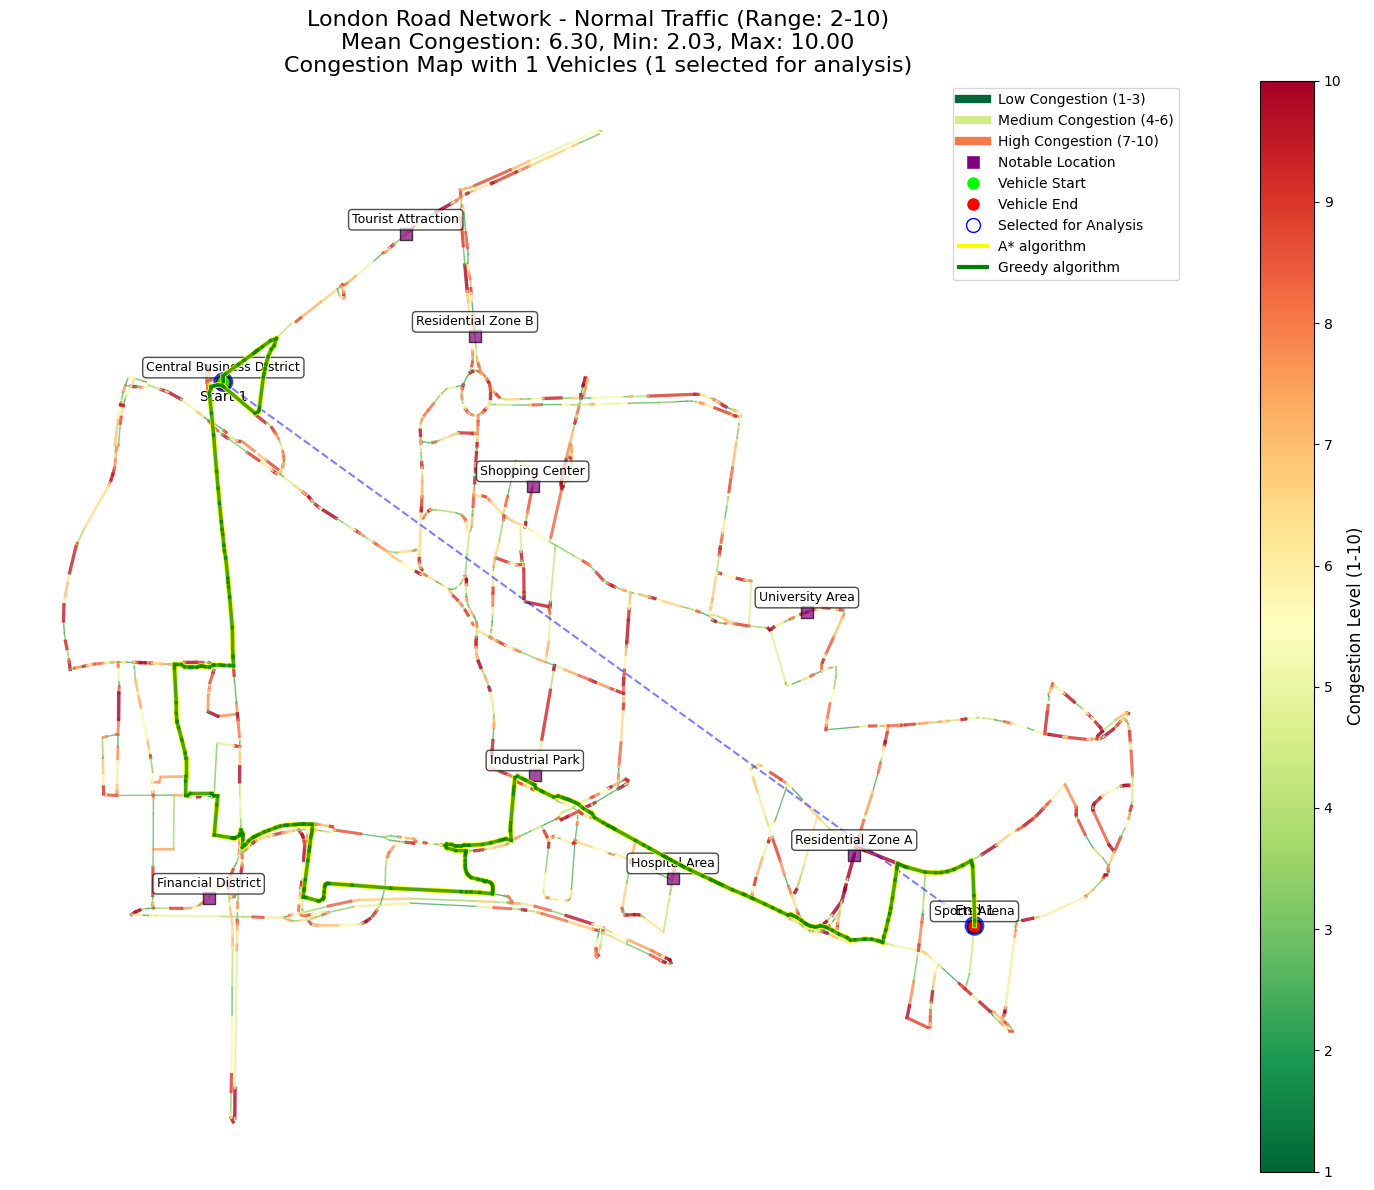


Current congestion statistics:
  Mean: 6.3006
  Median: 6.3484
  Min: 2.0257
  Max: 10.0000
  Std: 2.4658

Current vehicle count: 1
Vehicles selected for analysis: 1

=== London Traffic Simulation Menu ===
Congestion Scenarios:
1. Apply Normal congestion scenario
2. Apply Morning congestion scenario
3. Apply Evening congestion scenario
4. Apply Weekend congestion scenario
5. Apply Special congestion scenario

Vehicle Management:
A. Add a single vehicle with custom source/destination
B. Add 50 random vehicles
C. Add 100 random vehicles
D. Add 200 random vehicles
E. Remove all vehicles
S. Add multiple vehicles between specific source/destination

Route Analysis:
F. Select a vehicle for route analysis
G. Deselect all vehicles from analysis
H. Calculate routes for selected vehicles
I. Compare algorithms under current congestion

Congestion Impact Analysis:
L. Calculate and display vehicle impact on congestion
M. Export detailed impact report to Excel

Data Management:
J. Open latest Excel


Select an option (letter/number):  Z



Select a vehicle for iterative stress testing:
1. Vehicle 1: 12186456395 -> 1547013621


Select vehicle (number):  1



=== Starting Iterative Stress Test ===
Testing impact on Vehicle 1: 12186456395 -> 1547013621

Initial route before stress testing:

Algorithm Comparison for Vehicle 1
Algorithm  Path Length (nodes)  Travel Time (s)  Distance (m)  Computation Time (s)  Service Rate (routes/sec)  Avg Congestion  Max Congestion
       A*                  311      2126.227813   3546.277361              0.004212                 237.422393        7.977175            10.0
   Greedy                  311      3300.195927   3546.277361              0.002358                 424.095450        7.977175            10.0

Best travel time: A*
Highest service rate: Greedy

--- Stress Test Iteration 1 ---
Total vehicles so far: 1



How many vehicles to add in this iteration (or enter 0 to stop stress test):  100


Adding 100 vehicles along the route of Vehicle 1...
Added 100 vehicles in this iteration (total added: 100)
    Edge 6369329153_1163955130_0: OVERLOADED! Arrival rate 6.5 >= Service rate 1.0
    Edge 6369329156_10285308926_0: OVERLOADED! Arrival rate 6.5 >= Service rate 2.3
    Edge 6369329159_11223688559_0: OVERLOADED! Arrival rate 1.5 >= Service rate 1.1
    Edge 6369329158_1366095189_0: OVERLOADED! Arrival rate 6.5 >= Service rate 1.6
    Edge 8989843465_1596655163_0: OVERLOADED! Arrival rate 6.5 >= Service rate 1.4
    Edge 6369329163_9310662202_0: OVERLOADED! Arrival rate 6.5 >= Service rate 1.0
    Edge 6369329164_8868824843_0: OVERLOADED! Arrival rate 1.5 >= Service rate 1.2
    Edge 6369329167_1215563895_0: OVERLOADED! Arrival rate 6.5 >= Service rate 2.3
    Edge 6369329169_20965803_0: OVERLOADED! Arrival rate 6.5 >= Service rate 1.7
    Edge 6369329172_1366095187_0: OVERLOADED! Arrival rate 6.5 >= Service rate 1.6
    Edge 6509584408_25504760_0: OVERLOADED! Arrival rate 14.5 

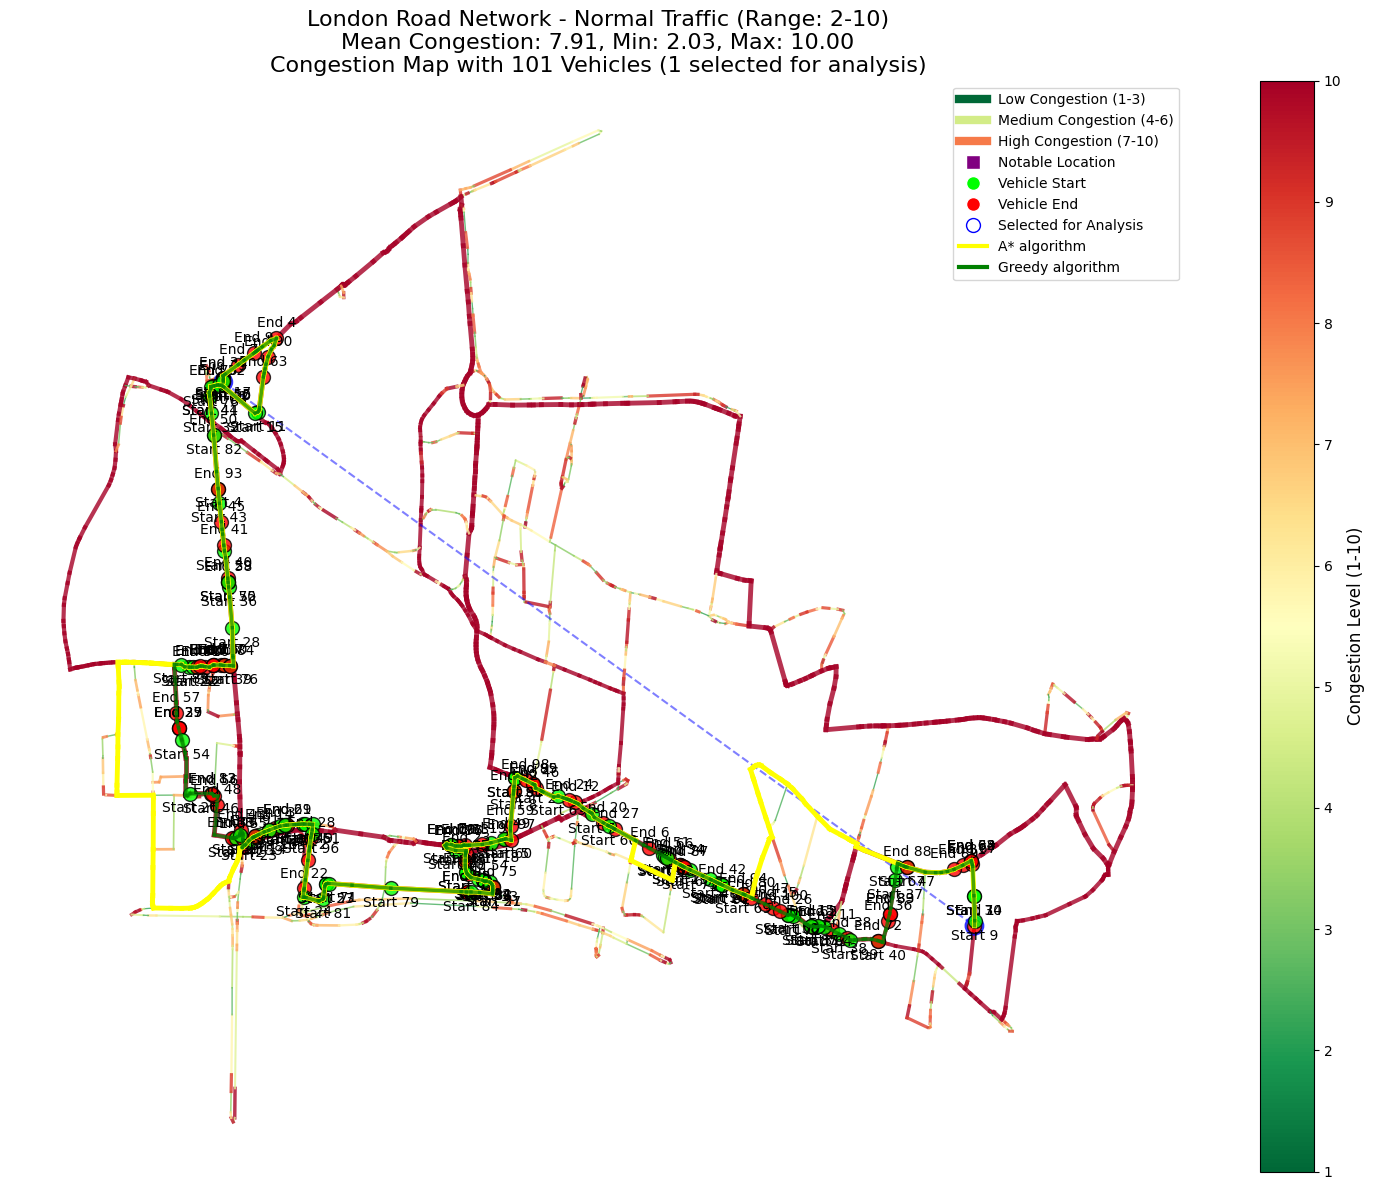


Route comparison after this iteration:

Algorithm Comparison for Vehicle 1
Algorithm  Path Length (nodes)  Travel Time (s)  Distance (m)  Computation Time (s)  Service Rate (routes/sec)  Avg Congestion  Max Congestion
       A*                  349      4807.675227   4122.813991              0.003964                 252.288962        8.812087            10.0
   Greedy                  311      5079.177718   3546.277361              0.002188                 457.045222        9.963471            10.0

Best travel time: A*
Highest service rate: Greedy

Press Enter to continue stress test or type 'V' to stop and view results: 


--- Stress Test Iteration 2 ---
Total vehicles so far: 101



How many vehicles to add in this iteration (or enter 0 to stop stress test):  1000


Adding 1000 vehicles along the route of Vehicle 1...
Added 1000 vehicles in this iteration (total added: 1100)
    Edge 6369329152_7553887509_0: OVERLOADED! Arrival rate 16.0 >= Service rate 2.0
    Edge 6369329153_1163955130_0: OVERLOADED! Arrival rate 72.5 >= Service rate 1.0
    Edge 6369329155_6369329159_0: OVERLOADED! Arrival rate 16.0 >= Service rate 1.6
    Edge 6369329156_10285308926_0: OVERLOADED! Arrival rate 72.5 >= Service rate 2.3
    Edge 6369329159_11223688559_0: OVERLOADED! Arrival rate 16.0 >= Service rate 1.1
    Edge 6369329158_1366095189_0: OVERLOADED! Arrival rate 72.5 >= Service rate 1.6
    Edge 8989843465_1596655163_0: OVERLOADED! Arrival rate 72.5 >= Service rate 1.4
    Edge 6369329163_9310662202_0: OVERLOADED! Arrival rate 72.5 >= Service rate 1.0
    Edge 6369329164_8868824843_0: OVERLOADED! Arrival rate 16.0 >= Service rate 1.2
    Edge 6369329162_11079475783_0: OVERLOADED! Arrival rate 16.0 >= Service rate 2.2
    Edge 6369329166_4870281310_0: OVERLOADED! 

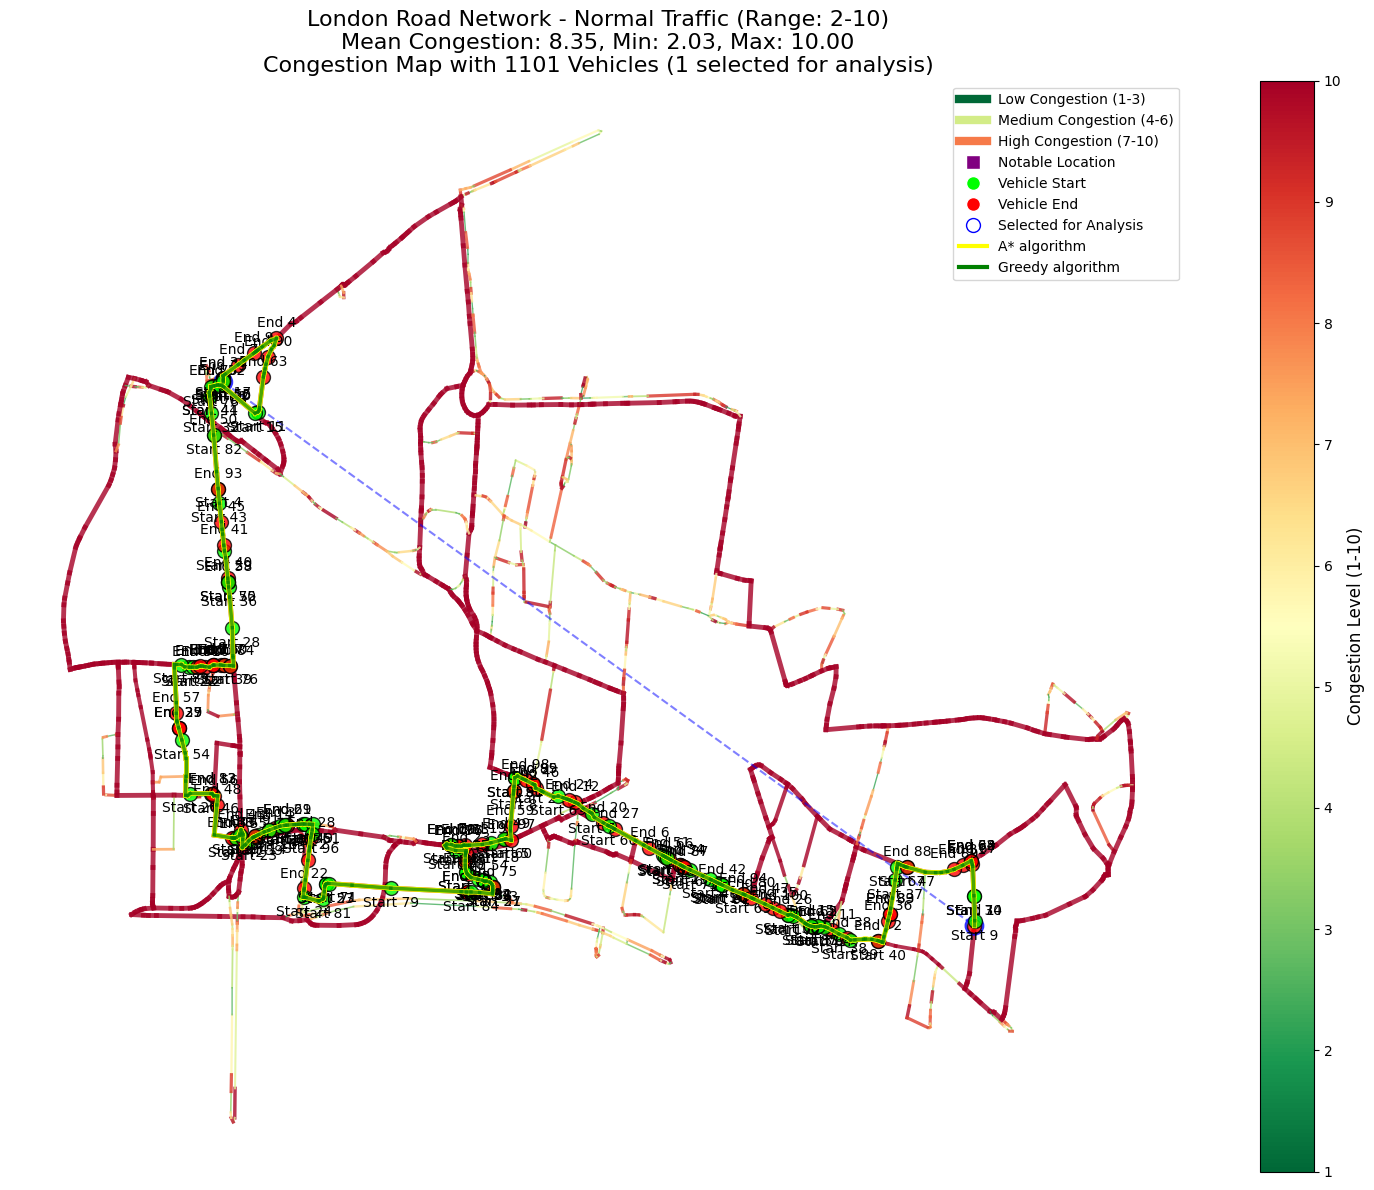


Route comparison after this iteration:

Algorithm Comparison for Vehicle 1
Algorithm  Path Length (nodes)  Travel Time (s)  Distance (m)  Computation Time (s)  Service Rate (routes/sec)  Avg Congestion  Max Congestion
       A*                  311      5079.177718   3546.277361              0.004005                 249.690677        9.963471            10.0
   Greedy                  311      5079.177718   3546.277361              0.002186                 457.493892        9.963471            10.0

Best travel time: A*
Highest service rate: Greedy

Press Enter to continue stress test or type 'V' to stop and view results: 


--- Stress Test Iteration 3 ---
Total vehicles so far: 1101


In [ ]:
def create_evenly_distributed_notable_locations(G):
    # Fixed notable locations for consistency
    landmark_names = [
        "Central Business District",
        "Financial District",
        "Shopping Center",
        "University Area",
        "Tourist Attraction",
        "Residential Zone A",
        "Residential Zone B",
        
        "Industrial Park",
        "Sports Arena",
        "Hospital Area"
    ]
    
    # For consistent node selection, use a fixed seed
    np.random.seed(42)
    
    # Get node positions
    node_positions = {}
    for node, data in G.nodes(data=True):
        if 'x' in data and 'y' in data:
            node_positions[node] = (data['x'], data['y'])
    
    if not node_positions:
        print("Warning: No nodes with position data found.")
        # Fall back to random nodes
        all_nodes = list(G.nodes())
        notable_locations = {}
        for i, name in enumerate(landmark_names):
            if i < len(all_nodes):
                notable_locations[name] = all_nodes[i]
        return notable_locations
    
    # Convert to numpy arrays for easy manipulation
    nodes = list(node_positions.keys())
    positions = np.array(list(node_positions.values()))
    
    # Find the bounding box of the map
    min_x, min_y = positions.min(axis=0)
    max_x, max_y = positions.max(axis=0)
    
    # Divide the map into a 3x4 grid (slightly larger than needed to ensure good coverage)
    grid_size_x = (max_x - min_x) / 3
    grid_size_y = (max_y - min_y) / 4
    
    notable_locations = {}
    grid_cells_used = set()
    
    # Try to pick nodes from different grid cells to ensure even distribution
    for name in landmark_names:
        # Try multiple times to find a good cell
        for _ in range(20):  # Limited attempts to avoid infinite loop
            # Pick a random grid cell that hasn't been used yet
            i = np.random.randint(0, 3)
            j = np.random.randint(0, 4)
            
            if (i, j) not in grid_cells_used:
                # Define the boundaries of this grid cell
                cell_min_x = min_x + i * grid_size_x
                cell_max_x = min_x + (i + 1) * grid_size_x
                cell_min_y = min_y + j * grid_size_y
                cell_max_y = min_y + (j + 1) * grid_size_y
                
                # Find nodes within this cell
                cell_nodes = []
                for node, (x, y) in node_positions.items():
                    if (cell_min_x <= x <= cell_max_x and 
                        cell_min_y <= y <= cell_max_y):
                        cell_nodes.append(node)
                
                if cell_nodes:
                    # Choose a random node from this cell
                    notable_locations[name] = np.random.choice(cell_nodes)
                    grid_cells_used.add((i, j))
                    break
        
        # If we still don't have a node for this landmark, pick a random one
        if name not in notable_locations and nodes:
            notable_locations[name] = np.random.choice(nodes)
    
    # Reset random seed for other operations
    np.random.seed()
    
    print("Created evenly distributed notable locations across the map")
    return notable_locations

def add_vehicle(G, vehicles, source, destination, congestion_data=None, calculate_routes=False):
    """Add a single vehicle with specific source and destination"""
    # Generate a unique ID for the vehicle
    vehicle_id = len(vehicles) + 1
    
    # Calculate the shortest path
    path = calculate_shortest_path(G, source, destination)
    
    if path is None:
        print(f"Could not add vehicle {vehicle_id}: No valid path")
        return None
    
    # Create the vehicle
    vehicle = Vehicle(vehicle_id, source, destination, path)
    
    # Calculate routes using all algorithms if requested
    if calculate_routes and congestion_data:
        vehicle = calculate_all_routes(G, vehicle, congestion_data)
    
    # Add vehicle to the collection
    vehicles.append(vehicle)
    
    # Update vehicle count on the path
    update_vehicle_counts_for_path(G, path, 1)
    
    print(f"Added vehicle {vehicle_id} from {source} to {destination} (path length: {len(path)} nodes)")
    return vehicle

def add_multiple_vehicles_manual(G, vehicles, source, destination, count, congestion_data=None, calculate_routes=False):
    """Add a specified number of vehicles with the same source and destination"""
    print(f"Adding {count} vehicles from {source} to {destination}...")
    
    # Calculate the shortest path to check if valid
    path = calculate_shortest_path(G, source, destination)
    
    if path is None:
        print(f"Could not add vehicles: No valid path between {source} and {destination}")
        return 0
    
    added_count = 0
    
    for _ in range(count):
        # Generate a unique ID for the vehicle
        vehicle_id = len(vehicles) + 1
        
        # Create the vehicle
        vehicle = Vehicle(vehicle_id, source, destination, path)
        
        # Calculate routes using all algorithms if requested
        if calculate_routes and congestion_data:
            vehicle = calculate_all_routes(G, vehicle, congestion_data)
        
        # Add vehicle to the collection
        vehicles.append(vehicle)
        
        # Update vehicle count on the path
        update_vehicle_counts_for_path(G, path, 1)
        
        added_count += 1
    
    print(f"Successfully added {added_count} vehicles from {source} to {destination}")
    return added_count

def add_stress_test_vehicles(G, vehicles, original_vehicle, congestion_data, original_congestion, count=20):
    """Add random vehicles along the path of an existing vehicle to stress test routing"""
    if not original_vehicle or not original_vehicle.path:
        print("Original vehicle has no valid path for stress testing")
        return 0
    
    print(f"Adding {count} stress test vehicles along the route of Vehicle {original_vehicle.id}...")
    
    # Get nodes along the original path
    path_nodes = original_vehicle.path.copy()
    
    # Save a copy of the original path for comparison
    original_path = original_vehicle.path.copy()
    
    # Ensure we have enough nodes for random placement
    if len(path_nodes) < 4:  # Need at least some variety
        # Extend with neighbors
        extended_nodes = set(path_nodes)
        for node in path_nodes:
            extended_nodes.update(list(G.neighbors(node)))
        path_nodes = list(extended_nodes)
    
    added_count = 0
    added_vehicles = []
    
    # Add vehicles with sources and destinations along the path
    for _ in range(count):
        if len(path_nodes) >= 2:
            # Select random source and destination from path nodes
            source = random.choice(path_nodes)
            # Ensure destination is different and preferably creates congestion on original path
            dest_candidates = [n for n in path_nodes if n != source]
            destination = random.choice(dest_candidates)
            
            # Calculate path for this stress test vehicle
            path = calculate_shortest_path(G, source, destination)
            
            if path:
                vehicle_id = len(vehicles) + 1
                vehicle = Vehicle(vehicle_id, source, destination, path)
                vehicles.append(vehicle)
                update_vehicle_counts_for_path(G, path, 1)
                added_count += 1
                added_vehicles.append(vehicle)
    
    print(f"Added {added_count} stress test vehicles")
    
    # Update congestion based on all the new vehicles
    update_congestion_based_on_vehicles(G, congestion_data, original_congestion)
    
    # Now recalculate the route for the original vehicle
    print(f"Recalculating route for Vehicle {original_vehicle.id} under new congestion conditions...")
    calculate_all_routes(G, original_vehicle, congestion_data)
    
    # Check if the path changed
    new_path = original_vehicle.path
    if new_path != original_path:
        print(f"Route changed due to increased congestion!")
        print(f"  Original path length: {len(original_path)} nodes")
        print(f"  New path length: {len(new_path)} nodes")
    else:
        print("Route remained the same despite increased congestion")
    
    # Detailed path comparison AFTER recalculating
    print("\nDetailed path comparison:")
    
    # Only show first few and last few nodes if paths are long
    if len(original_path) > 10:
        orig_display = f"{original_path[:5]} ... {original_path[-5:]}"
        new_display = f"{new_path[:5]} ... {new_path[-5:]}" if len(new_path) > 10 else str(new_path)
        print(f"Original path: {orig_display}")
        print(f"New path: {new_display}")
    else:
        print(f"Original path: {original_path}")
        print(f"New path: {new_path}")
    
    # Check how many nodes are different
    diff_count = sum(1 for x, y in zip(original_path, new_path) if x != y)
    if len(original_path) != len(new_path):
        diff_count += abs(len(original_path) - len(new_path))
        
    diff_percentage = (diff_count / max(len(original_path), len(new_path))) * 100
    print(f"Route difference: {diff_percentage:.1f}% of nodes are different")
    
    # Check if travel times actually changed
    if 'A*' in original_vehicle.travel_times:
        print(f"Travel time impact: {original_vehicle.travel_times['A*']:.2f}s (new) vs previous (recalculate to get old)")
    
    return added_count, added_vehicles

def add_bulk_vehicles(G, vehicles, count, congestion_data=None, calculate_routes=False, notable_locations=None):
    """Add a specified number of vehicles with random source and destination"""
    print(f"Adding {count} vehicles with random routes...")
    
    nodes = list(G.nodes())
    added_count = 0
    
    # If notable locations provided, use them with higher probability
    if notable_locations and len(notable_locations) >= 2:
        notable_nodes = list(notable_locations.values())
    else:
        notable_nodes = []
    
    for _ in range(count):
        # With 70% probability, use notable locations if available
        if notable_nodes and random.random() < 0.7:
            source = random.choice(notable_nodes)
            
            # Make sure destination is different from source
            possible_destinations = [n for n in notable_nodes if n != source]
            if possible_destinations:
                destination = random.choice(possible_destinations)
            else:
                # Fall back to random node if needed
                destination = random.choice(nodes)
                while destination == source:
                    destination = random.choice(nodes)
        else:
            # Random source and destination
            source = random.choice(nodes)
            destination = random.choice(nodes)
            while destination == source:
                destination = random.choice(nodes)
        
        # Add the vehicle
        vehicle = add_vehicle(G, vehicles, source, destination, congestion_data, calculate_routes)
        
        if vehicle:
            added_count += 1
    
    print(f"Successfully added {added_count} vehicles")
    return added_count

def select_from_notable_locations(notable_locations, prompt):
    """Helper function to select a location from the notable locations"""
    print("\n" + prompt)
    for i, (name, _) in enumerate(notable_locations.items()):
        print(f"{i+1}. {name}")
    
    try:
        choice = int(input("Select location (number): "))
        if 1 <= choice <= len(notable_locations):
            selected_name = list(notable_locations.keys())[choice-1]
            selected_node = list(notable_locations.values())[choice-1]
            print(f"Selected: {selected_name} (Node: {selected_node})")
            return selected_node
        else:
            print("Invalid choice.")
            return None
    except ValueError:
        print("Invalid input. Please enter a number.")
        return None

def export_analysis_to_excel(G, vehicles, congestion_data, scenario, selected_vehicle=None):
    """
    Export all analysis and calculations to an Excel file
    
    Parameters:
    - G: Graph representing the road network
    - vehicles: List of all vehicles
    - congestion_data: Current congestion data
    - scenario: Current scenario name
    - selected_vehicle: Specific vehicle to highlight in detailed analysis (optional)
    
    Returns:
    - Path to the created Excel file
    """
    import pandas as pd
    import os
    import time
    import numpy as np
    from openpyxl import Workbook
    from openpyxl.styles import PatternFill, Font, Alignment, Border, Side
    from openpyxl.utils.dataframe import dataframe_to_rows
    from openpyxl.chart import BarChart, Reference, LineChart, ScatterChart, Series
    
    print("Creating comprehensive analysis Excel file...")
    
    # Create output directory if it doesn't exist
    analysis_dir = os.path.join('london_simulation', 'analysis_reports')
    os.makedirs(analysis_dir, exist_ok=True)
    
    # Create a timestamp for the filename
    timestamp = int(time.time())
    excel_file = os.path.join(analysis_dir, f"traffic_analysis_{scenario.replace(' ', '_')}_{timestamp}.xlsx")
    
    # Create a new Excel workbook
    wb = Workbook()
    
    # Remove default worksheet
    ws0 = wb.active
    wb.remove(ws0)
    
    # 1. Summary sheet
    ws_summary = wb.create_sheet("Summary")
    
    # Summary information
    summary_data = [
        ["London Traffic Simulation Analysis Report"],
        [""],
        ["Generated on:", time.strftime("%Y-%m-%d %H:%M:%S")],
        ["Scenario:", scenario],
        ["Total vehicles:", len(vehicles)],
        ["Selected vehicles:", sum(1 for v in vehicles if v.selected_for_analysis)],
        [""],
        ["Congestion Statistics:"],
        ["Mean congestion:", np.mean(list(congestion_data.values()))],
        ["Min congestion:", np.min(list(congestion_data.values()))],
        ["Max congestion:", np.max(list(congestion_data.values()))],
        ["Standard deviation:", np.std(list(congestion_data.values()))],
    ]
    
    for row in summary_data:
        ws_summary.append(row)
    
    # Format summary sheet
    ws_summary.merge_cells('A1:B1')
    ws_summary['A1'].font = Font(bold=True, size=14)
    
    # 2. Vehicle List sheet
    ws_vehicles = wb.create_sheet("Vehicle List")
    
    # Create DataFrame for all vehicles
    vehicle_data = []
    for v in vehicles:
        # Get best algorithm if available
        best_algo = None
        best_time = float('inf')
        if v.travel_times:
            best_algo, best_time = min(v.travel_times.items(), key=lambda x: x[1])
        
        # Check if this vehicle has been analyzed with all algorithms
        algorithms_used = len(v.paths)
        
        vehicle_data.append({
            'Vehicle ID': v.id,
            'Source': v.source,
            'Destination': v.destination,
            'Path Length': len(v.path) if v.path else 0,
            'Selected for Analysis': "Yes" if v.selected_for_analysis else "No",
            'Best Algorithm': best_algo if best_algo else "N/A",
            'Best Travel Time': best_time if best_time != float('inf') else "N/A",
            'Algorithms Used': algorithms_used
        })
    
    # Convert to DataFrame
    df_vehicles = pd.DataFrame(vehicle_data)
    if not df_vehicles.empty:
        # Write to Excel
        for r in dataframe_to_rows(df_vehicles, index=False, header=True):
            ws_vehicles.append(r)
    else:
        ws_vehicles.append(["No vehicles in simulation"])
    
    # 3. Algorithm Comparison sheet
    ws_algo = wb.create_sheet("Algorithm Comparison")
    
    # Get data for vehicles that have been analyzed with multiple algorithms
    analyzed_vehicles = [v for v in vehicles if len(v.paths) > 1]
    
    if analyzed_vehicles:
        # First, create summary of which algorithm performs best most often
        algo_counts = {'Dijkstra': 0, 'A*': 0, 'Greedy': 0, 'Cost-Efficient': 0}
        for v in analyzed_vehicles:
            if v.travel_times:
                best_algo = min(v.travel_times.items(), key=lambda x: x[1])[0]
                if best_algo in algo_counts:
                    algo_counts[best_algo] += 1
        
        ws_algo.append(["Algorithm Performance Summary"])
        ws_algo.append(["Algorithm", "Best Count", "Percentage"])
        
        for algo, count in algo_counts.items():
            if count > 0:
                percentage = (count / len(analyzed_vehicles)) * 100
                ws_algo.append([algo, count, f"{percentage:.1f}%"])
        
        ws_algo.append([])
        ws_algo.append(["Detailed Algorithm Comparison by Vehicle"])
        ws_algo.append([])
        
        # Then add detailed comparison for each analyzed vehicle
        for v in analyzed_vehicles:
            ws_algo.append([f"Vehicle {v.id}: {v.source} -> {v.destination}"])
            
            # Create comparison table for this vehicle
            algo_data = []
            for algo_name, path in v.paths.items():
                if not path:
                    continue
                
                algo_data.append({
                    'Algorithm': algo_name,
                    'Path Length': len(path),
                    'Travel Time (s)': v.travel_times.get(algo_name, "N/A"),
                    'Computation Time (s)': v.computation_times.get(algo_name, "N/A")
                })
            
            if algo_data:
                # Convert to DataFrame and sort by travel time
                df_algo = pd.DataFrame(algo_data)
                df_algo = df_algo.sort_values('Travel Time (s)')
                
                # Write to Excel
                for r in dataframe_to_rows(df_algo, index=False, header=True):
                    ws_algo.append(r)
                
                ws_algo.append([])
    else:
        ws_algo.append(["No vehicles have been analyzed with multiple algorithms"])
    
    # 4. Congestion Data sheet
    ws_congestion = wb.create_sheet("Congestion Data")
    
    # Create DataFrame for congestion data
    congestion_rows = []
    for u, v, k in G.edges(keys=True):
        edge_id = f"{u}_{v}_{k}"
        if edge_id in congestion_data:
            congestion_level = congestion_data[edge_id]
            vehicle_count = G[u][v][k].get('vehicle_count', 0)
            
            # Get MM1 statistics if available
            mm1_stats = G[u][v][k].get('mm1_stats')
            if mm1_stats and mm1_stats['system_stable']:
                utilization = mm1_stats['utilization']
                avg_vehicles = mm1_stats['avg_vehicles_in_system']
                avg_time = mm1_stats['avg_time_in_system']
            else:
                utilization = "N/A"
                avg_vehicles = "N/A"
                avg_time = "N/A"
            
            congestion_rows.append({
                'Edge ID': edge_id,
                'Source': u,
                'Target': v,
                'Key': k,
                'Congestion Level': congestion_level,
                'Vehicle Count': vehicle_count,
                'Length (m)': G[u][v][k].get('length', 0),
                'MM1 Utilization': utilization,
                'MM1 Avg Vehicles': avg_vehicles,
                'MM1 Avg Time': avg_time
            })
    
    # Convert to DataFrame and sort by congestion level
    df_congestion = pd.DataFrame(congestion_rows)
    if not df_congestion.empty:
        df_congestion = df_congestion.sort_values('Congestion Level', ascending=False)
        
        # Write to Excel
        for r in dataframe_to_rows(df_congestion, index=False, header=True):
            ws_congestion.append(r)
    else:
        ws_congestion.append(["No congestion data available"])
    
    # 5. Detailed Vehicle Analysis sheet (if a specific vehicle is selected)
    if selected_vehicle:
        ws_detail = wb.create_sheet(f"Vehicle {selected_vehicle.id} Detail")
        
        ws_detail.append([f"Detailed Analysis for Vehicle {selected_vehicle.id}"])
        ws_detail.append(["Source:", selected_vehicle.source])
        ws_detail.append(["Destination:", selected_vehicle.destination])
        ws_detail.append([])
        
        # Path details
        if selected_vehicle.path:
            ws_detail.append(["Current Path:"])
            ws_detail.append(["Node", "Coordinates (x,y)", "Congestion"])
            
            for i, node in enumerate(selected_vehicle.path):
                x = G.nodes[node].get('x', 'N/A')
                y = G.nodes[node].get('y', 'N/A')
                
                # Get average congestion of edges leading to this node
                congestion = "N/A"
                if i > 0:
                    prev_node = selected_vehicle.path[i-1]
                    edge_id = f"{prev_node}_{node}_0"  # Assuming key=0 for simplicity
                    congestion = congestion_data.get(edge_id, "N/A")
                
                ws_detail.append([node, f"({x}, {y})", congestion])
            
            ws_detail.append([])
        
        # Algorithm comparison
        if selected_vehicle.paths:
            ws_detail.append(["Algorithm Comparison:"])
            
            algo_data = []
            for algo_name, path in selected_vehicle.paths.items():
                if not path:
                    continue
                
                algo_data.append({
                    'Algorithm': algo_name,
                    'Path Length': len(path),
                    'Travel Time (s)': selected_vehicle.travel_times.get(algo_name, "N/A"),
                    'Computation Time (s)': selected_vehicle.computation_times.get(algo_name, "N/A"),
                    'Service Rate (routes/sec)': selected_vehicle.service_rates.get(algo_name, "N/A")  # ← ADD THIS LINE
                })
            
            if algo_data:
                # Convert to DataFrame and sort by travel time
                df_algo = pd.DataFrame(algo_data)
                df_algo = df_algo.sort_values('Travel Time (s)')
                
                # Write to Excel
                for r in dataframe_to_rows(df_algo, index=False, header=True):
                    ws_detail.append(r)
    
    # Save the workbook
    wb.save(excel_file)
    print(f"Analysis exported to {excel_file}")
    
    return excel_file

def export_stress_test_analysis(G, original_vehicle, original_path, congestion_data, original_congestion, added_vehicles):
    """
    Export detailed analysis of a stress test, including before and after comparison
    
    Parameters:
    - G: Graph representing the road network
    - original_vehicle: The vehicle that was stress tested
    - original_path: The original path before stress testing
    - congestion_data: Current congestion data (after stress test)
    - original_congestion: Original congestion data (before stress test)
    - added_vehicles: List of vehicles added during stress test
    
    Returns:
    - Path to the created Excel file
    """
    import pandas as pd
    import os
    import time
    import numpy as np
    from openpyxl import Workbook
    from openpyxl.styles import PatternFill, Font, Alignment, Border, Side
    from openpyxl.utils.dataframe import dataframe_to_rows
    from openpyxl.chart import BarChart, Reference, LineChart, ScatterChart, Series
    
    print("Creating stress test analysis Excel file...")
    
    # Create output directory if it doesn't exist
    analysis_dir = os.path.join('london_simulation', 'stress_test_reports')
    os.makedirs(analysis_dir, exist_ok=True)
    
    # Create a timestamp for the filename
    timestamp = int(time.time())
    excel_file = os.path.join(analysis_dir, f"stress_test_vehicle_{original_vehicle.id}_{timestamp}.xlsx")
    
    # Create a new Excel workbook
    wb = Workbook()
    
    # Remove default worksheet
    ws0 = wb.active
    wb.remove(ws0)
    
    # 1. Summary sheet
    ws_summary = wb.create_sheet("Summary")
    
    # Summary information
    summary_data = [
        ["Stress Test Analysis Report"],
        [""],
        ["Generated on:", time.strftime("%Y-%m-%d %H:%M:%S")],
        ["Vehicle ID:", original_vehicle.id],
        ["Source:", original_vehicle.source],
        ["Destination:", original_vehicle.destination],
        ["Stress test vehicles added:", len(added_vehicles)],
        [""],
        ["Path Comparison:"],
        ["Original path length:", len(original_path)],
        ["New path length:", len(original_vehicle.path)],
    ]
    
    # Calculate path difference
    if original_path != original_vehicle.path:
        diff_count = sum(1 for x, y in zip(original_path, original_vehicle.path) if x != y)
        if len(original_path) != len(original_vehicle.path):
            diff_count += abs(len(original_path) - len(original_vehicle.path))
            
        diff_percentage = (diff_count / max(len(original_path), len(original_vehicle.path))) * 100
        summary_data.append(["Path difference:", f"{diff_percentage:.1f}% of nodes are different"])
        
        # Compare travel times if available
        if 'A*' in original_vehicle.travel_times:
            # We don't have original travel times stored, but can add if available
            summary_data.append(["Current travel time:", f"{original_vehicle.travel_times['A*']:.2f}s"])
    else:
        summary_data.append(["Path difference:", "No change in path"])
    
    for row in summary_data:
        ws_summary.append(row)
    
    # Format summary sheet
    ws_summary.merge_cells('A1:B1')
    ws_summary['A1'].font = Font(bold=True, size=14)
    
    # 2. Path Comparison sheet
    ws_path = wb.create_sheet("Path Comparison")
    
    # Create table comparing before and after paths
    ws_path.append(["Path Node Comparison: Before vs After Stress Test"])
    ws_path.append([])
    
    # Determine max path length
    max_length = max(len(original_path), len(original_vehicle.path))
    
    # Create headers
    ws_path.append(["Node Index", "Original Path Node", "New Path Node", "Changed?"])
    
    # Add path comparison
    for i in range(max_length):
        orig_node = original_path[i] if i < len(original_path) else "N/A"
        new_node = original_vehicle.path[i] if i < len(original_vehicle.path) else "N/A"
        changed = "Yes" if orig_node != new_node else "No"
        
        ws_path.append([i, orig_node, new_node, changed])
    
    # 3. Congestion Comparison sheet
    ws_congestion = wb.create_sheet("Congestion Comparison")
    
    # Create table comparing before and after congestion
    ws_congestion.append(["Congestion Comparison: Before vs After Stress Test"])
    ws_congestion.append([])
    
    # Create data for comparison
    congestion_rows = []
    
    # Focus on edges that are part of either path
    path_edges = set()
    
    # Get edges from original path
    for i in range(len(original_path) - 1):
        u, v = original_path[i], original_path[i+1]
        if u in G and v in G[u]:
            for k in G[u][v]:
                path_edges.add((u, v, k))
    
    # Get edges from new path
    for i in range(len(original_vehicle.path) - 1):
        u, v = original_vehicle.path[i], original_vehicle.path[i+1]
        if u in G and v in G[u]:
            for k in G[u][v]:
                path_edges.add((u, v, k))
    
    # Add data for each edge
    for u, v, k in path_edges:
        edge_id = f"{u}_{v}_{k}"
        
        # Get before and after congestion
        before_congestion = original_congestion.get(edge_id, 1.0)
        after_congestion = congestion_data.get(edge_id, 1.0)
        
        # Calculate change
        change = after_congestion - before_congestion
        percent_change = (change / before_congestion) * 100 if before_congestion > 0 else 0
        
        # Get vehicle count
        vehicle_count = G[u][v][k].get('vehicle_count', 0)
        
        # Get edge information
        length = G[u][v][k].get('length', 0)
        
        # Check if edge is in original path
        in_original = False
        for i in range(len(original_path) - 1):
            if original_path[i] == u and original_path[i+1] == v:
                in_original = True
                break
        
        # Check if edge is in new path
        in_new = False
        for i in range(len(original_vehicle.path) - 1):
            if original_vehicle.path[i] == u and original_vehicle.path[i+1] == v:
                in_new = True
                break
        
        # Get MM1 statistics if available
        mm1_stats = G[u][v][k].get('mm1_stats')
        if mm1_stats and mm1_stats.get('system_stable', False):
            utilization = mm1_stats.get('utilization', 'N/A')
            avg_vehicles = mm1_stats.get('avg_vehicles_in_system', 'N/A')
        else:
            utilization = "N/A"
            avg_vehicles = "N/A"
        
        congestion_rows.append({
            'Edge ID': edge_id,
            'Source': u,
            'Target': v,
            'Length (m)': length,
            'Before Congestion': before_congestion,
            'After Congestion': after_congestion,
            'Absolute Change': change,
            'Percent Change (%)': percent_change,
            'Vehicle Count': vehicle_count,
            'In Original Path': "Yes" if in_original else "No",
            'In New Path': "Yes" if in_new else "No",
            'MM1 Utilization': utilization,
            'MM1 Avg Vehicles': avg_vehicles
        })
    
    # Convert to DataFrame and sort by percent change
    df_congestion = pd.DataFrame(congestion_rows)
    if not df_congestion.empty:
        df_congestion = df_congestion.sort_values('Percent Change (%)', ascending=False)
        
        # Write to Excel
        for r in dataframe_to_rows(df_congestion, index=False, header=True):
            ws_congestion.append(r)
    else:
        ws_congestion.append(["No congestion data available"])
    
    # 4. Stress Test Vehicles sheet
    ws_vehicles = wb.create_sheet("Stress Test Vehicles")
    
    # Create table of added vehicles
    ws_vehicles.append(["Vehicles Added During Stress Test"])
    ws_vehicles.append([])
    
    vehicle_rows = []
    for v in added_vehicles:
        vehicle_rows.append({
            'Vehicle ID': v.id,
            'Source': v.source,
            'Destination': v.destination,
            'Path Length': len(v.path) if v.path else 0
        })
    
    # Convert to DataFrame
    df_vehicles = pd.DataFrame(vehicle_rows)
    if not df_vehicles.empty:
        # Write to Excel
        for r in dataframe_to_rows(df_vehicles, index=False, header=True):
            ws_vehicles.append(r)
    else:
        ws_vehicles.append(["No vehicles added during stress test"])
    
    # 5. Algorithm Comparison sheet (if multiple algorithms were used)
    if len(original_vehicle.paths) > 1:
        ws_algo = wb.create_sheet("Algorithm Comparison")
        
        ws_algo.append(["Algorithm Comparison After Stress Test"])
        ws_algo.append([])
        
        algo_rows = []
        for algo_name, path in original_vehicle.paths.items():
            if not path:
                continue
            
            travel_time = original_vehicle.travel_times.get(algo_name, 'N/A')
            comp_time = original_vehicle.computation_times.get(algo_name, 'N/A')
            
            algo_rows.append({
                'Algorithm': algo_name,
                'Path Length': len(path),
                'Travel Time (s)': travel_time,
                'Computation Time (s)': comp_time
            })
        
        # Convert to DataFrame and sort by travel time
        df_algo = pd.DataFrame(algo_rows)
        if not df_algo.empty:
            df_algo = df_algo.sort_values('Travel Time (s)')
            
            # Write to Excel
            for r in dataframe_to_rows(df_algo, index=False, header=True):
                ws_algo.append(r)
        else:
            ws_algo.append(["No algorithm comparison data available"])
    
    # Save the workbook
    wb.save(excel_file)
    print(f"Stress test analysis exported to {excel_file}")
    
    return excel_file

def print_algorithm_comparison_table(G, vehicle, congestion_data):
    """Print a table comparing the performance of A* and Greedy algorithms for a vehicle"""
    if not vehicle.paths:
        print("No paths calculated for this vehicle")
        return
    
    # Create congestion graph to get accurate travel times
    G_congestion = create_congestion_graph(G, congestion_data)
    
    # Calculate travel times and distances for each path
    results = []
    
    for algo_name, path in vehicle.paths.items():
        if not path or len(path) < 2:
            continue
        
        if algo_name == 'Greedy':
            # Greedy stores distance, calculate actual travel time for comparison
            stored_distance = vehicle.travel_times.get(algo_name, 0)
            
            # Calculate actual travel time using congestion graph
            actual_travel_time = 0
            total_congestion = 0
            max_congestion = 0
            
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                if u in G_congestion and v in G_congestion[u]:
                    actual_travel_time += G_congestion[u][v]['travel_time']
                    congestion = G_congestion[u][v].get('congestion', 1.0)
                    total_congestion += congestion
                    max_congestion = max(max_congestion, congestion)
            
            avg_congestion = total_congestion / (len(path) - 1) if len(path) > 1 else 0
            
            results.append({
                'Algorithm': algo_name,
                'Path Length (nodes)': len(path),
                'Travel Time (s)': actual_travel_time,
                'Distance (m)': stored_distance,
                'Computation Time (s)': vehicle.computation_times.get(algo_name, 0),
                'Service Rate (routes/sec)': vehicle.service_rates.get(algo_name, 0),
                'Avg Congestion': avg_congestion,
                'Max Congestion': max_congestion
            })
        else:
            # A* stores travel time normally
            travel_time = vehicle.travel_times.get(algo_name, 0)
            
            # Calculate total distance and congestion
            total_distance = 0
            total_congestion = 0
            max_congestion = 0
            
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                if u in G_congestion and v in G_congestion[u]:
                    total_distance += G_congestion[u][v]['length']
                    congestion = G_congestion[u][v].get('congestion', 1.0)
                    total_congestion += congestion
                    max_congestion = max(max_congestion, congestion)
            
            avg_congestion = total_congestion / (len(path) - 1) if len(path) > 1 else 0
            
            results.append({
                'Algorithm': algo_name,
                'Path Length (nodes)': len(path),
                'Travel Time (s)': travel_time,
                'Distance (m)': total_distance,
                'Computation Time (s)': vehicle.computation_times.get(algo_name, 0),
                'Service Rate (routes/sec)': vehicle.service_rates.get(algo_name, 0),
                'Avg Congestion': avg_congestion,
                'Max Congestion': max_congestion
            })
    
    # Convert to DataFrame for easy display
    df = pd.DataFrame(results)
    
    # Sort by travel time
    df = df.sort_values('Travel Time (s)')
    
    # Print the table
    print("\nAlgorithm Comparison for Vehicle", vehicle.id)
    print(df.to_string(index=False))
    
    # Show best algorithm by different metrics
    if not df.empty:
        best_time = df.loc[df['Travel Time (s)'].idxmin(), 'Algorithm']
        best_service_rate = df.loc[df['Service Rate (routes/sec)'].idxmax(), 'Algorithm']
        print(f"\nBest travel time: {best_time}")
        print(f"Highest service rate: {best_service_rate}")
    
    return df
def simple_algorithm_comparison_table(G, vehicle, congestion_data):
    """
    SIMPLIFIED VERSION: Fallback comparison table that avoids complex edge data access
    Use this if the main function still has issues
    """
    if not vehicle.paths:
        print("No paths calculated for this vehicle")
        return
    
    print(f"\nSimple Algorithm Comparison for Vehicle {vehicle.id}")
    print("=" * 60)
    
    results = []
    
    for algo_name, path in vehicle.paths.items():
        if not path:
            continue
            
        # Get basic metrics from vehicle object
        travel_time = vehicle.travel_times.get(algo_name, 0)
        comp_time = vehicle.computation_times.get(algo_name, 0)
        service_rate = vehicle.service_rates.get(algo_name, 0)
        
        results.append({
            'Algorithm': algo_name,
            'Path Length': len(path),
            'Travel Time/Distance': travel_time,  # Time for A*, Distance for Greedy
            'Computation Time': comp_time,
            'Service Rate': service_rate
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    if not df.empty:
        print(df.to_string(index=False, float_format='%.4f'))
        
        # Show best by service rate
        best_service = df.loc[df['Service Rate'].idxmax(), 'Algorithm']
        print(f"\nHighest service rate: {best_service}")
        
        # Show optimization focus
        print(f"\nNote: A* optimizes for travel time, Greedy optimizes for distance")
    
    return df

def safe_get_edge_data(G, u, v, key, attribute, default=0):
    """
    UTILITY FUNCTION: Safely get edge data attribute with fallbacks
    """
    try:
        # Method 1: Try G[u][v][key]
        if u in G and v in G[u] and key in G[u][v]:
            edge_data = G[u][v][key]
            if isinstance(edge_data, dict):
                return edge_data.get(attribute, default)
        
        # Method 2: Try G.edges
        edge_attrs = G.edges[u, v, key]
        if isinstance(edge_attrs, dict):
            return edge_attrs.get(attribute, default)
        elif isinstance(edge_attrs, (int, float)) and attribute == 'travel_time':
            return float(edge_attrs)
        
        # Method 3: Try get_edge_data
        edge_data = G.get_edge_data(u, v, key)
        if isinstance(edge_data, dict):
            return edge_data.get(attribute, default)
            
    except Exception:
        pass
    
    return default
def print_travel_time_analysis_summary(G, vehicles, congestion_data):
    """
    NEW FUNCTION: Analyze travel time penalties across all vehicles
    """
    print("\n=== Travel Time Analysis Summary ===")
    
    if not vehicles:
        print("No vehicles available for analysis")
        return
    
    # Create congestion graph
    G_congestion = create_congestion_graph(G, congestion_data)
    
    # Analyze all vehicles with calculated paths
    analyzed_vehicles = [v for v in vehicles if v.paths and 'A*' in v.paths]
    
    if not analyzed_vehicles:
        print("No vehicles with calculated A* paths available")
        return
    
    print(f"Analyzing {len(analyzed_vehicles)} vehicles with calculated routes:")
    
    total_base_time = 0
    total_actual_time = 0
    congestion_impacts = []
    
    for vehicle in analyzed_vehicles:
        if 'A*' not in vehicle.paths:
            continue
            
        path = vehicle.paths['A*']
        if len(path) < 2:
            continue
        
        # Calculate base vs actual travel time for this vehicle
        base_time = 0
        actual_time = vehicle.travel_times.get('A*', 0)
        
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            if u in G_congestion and v in G_congestion[u]:
                edge_keys = list(G_congestion[u][v].keys())
                if edge_keys:
                    edge_data = G_congestion[u][v][edge_keys[0]]
                    base_time += edge_data.get('base_travel_time', 0)
        
        if base_time > 0:
            congestion_impact = ((actual_time - base_time) / base_time) * 100
            congestion_impacts.append(congestion_impact)
            total_base_time += base_time
            total_actual_time += actual_time
    
    if congestion_impacts:
        avg_impact = sum(congestion_impacts) / len(congestion_impacts)
        max_impact = max(congestion_impacts)
        min_impact = min(congestion_impacts)
        
        overall_impact = ((total_actual_time - total_base_time) / total_base_time) * 100 if total_base_time > 0 else 0
        
        print(f"\nCongestion Impact on Travel Times:")
        print(f"  Average penalty: {avg_impact:.1f}%")
        print(f"  Maximum penalty: {max_impact:.1f}%")
        print(f"  Minimum penalty: {min_impact:.1f}%")
        print(f"  Overall network penalty: {overall_impact:.1f}%")
        
        # Categorize impact severity
        if overall_impact < 10:
            print(f"  📊 Network Status: Minimal congestion impact")
        elif overall_impact < 25:
            print(f"  📊 Network Status: Moderate congestion impact")
        elif overall_impact < 50:
            print(f"  📊 Network Status: High congestion impact")
        else:
            print(f"  📊 Network Status: Severe congestion impact")
            
        print(f"\nTotal time saved by fixing double penalization:")
        print(f"  Previous system would have added ~{overall_impact:.1f}% more penalties")
        print(f"  Current system uses realistic single penalties")
    else:
        print("No travel time data available for analysis")
def recalculate_routes_for_selected_vehicles(G, vehicles, congestion_data, scenario):
    """Recalculate routes for all selected vehicles under current congestion"""
    selected_vehicles = [v for v in vehicles if v.selected_for_analysis]
    
    if not selected_vehicles:
        print("No vehicles selected for analysis")
        return
    
    print(f"\nRecalculating routes for {len(selected_vehicles)} selected vehicles under {scenario} scenario...")
    
    # Summary results
    summary = []
    
    for vehicle in selected_vehicles:
        print(f"\nVehicle {vehicle.id}: {vehicle.source} -> {vehicle.destination}")
        
        # Calculate new routes
        calculate_all_routes(G, vehicle, congestion_data)
        
        # Print comparison table
        result_df = print_algorithm_comparison_table(G, vehicle, congestion_data)
        
        # Add to summary
        if result_df is not None and not result_df.empty:
            best_time_row = result_df.loc[result_df['Travel Time (s)'].idxmin()]
            best_service_row = result_df.loc[result_df['Service Rate (routes/sec)'].idxmax()]
            
            summary.append({
                'Vehicle ID': vehicle.id,
                'Source': vehicle.source,
                'Destination': vehicle.destination,
                'Best Time Algorithm': best_time_row['Algorithm'],
                'Best Time (s)': best_time_row['Travel Time (s)'],
                'Highest Service Rate Algorithm': best_service_row['Algorithm'], 
                'Highest Service Rate': best_service_row['Service Rate (routes/sec)'],
                'Scenario': scenario
            })
    
    # Print summary table
    if summary:
        summary_df = pd.DataFrame(summary)
        print("\nSummary of Algorithm Performance for Selected Vehicles:")
        print(summary_df.to_string(index=False))
        
        # Count algorithm performance
        time_algo_counts = summary_df['Best Time Algorithm'].value_counts()
        service_algo_counts = summary_df['Highest Service Rate Algorithm'].value_counts()
        
        print("\nPerformance Summary:")
        print("Best Travel Time:")
        for algo, count in time_algo_counts.items():
            print(f"  {algo}: {count} out of {len(summary_df)} cases ({count/len(summary_df)*100:.1f}%)")
        
        print("Highest Service Rate:")
        for algo, count in service_algo_counts.items():
            print(f"  {algo}: {count} out of {len(summary_df)} cases ({count/len(summary_df)*100:.1f}%)")
    
    # Display the updated map with routes
    print("\nUpdated map showing all calculated routes:")
    enhanced_visualize_congestion_map(G, congestion_data, vehicles, scenario, None)
    
    return summary

def run_interactive_congestion_simulation():
    """Run the interactive congestion simulation with vehicles and route analysis"""
    # Load the London network
    G = load_london_network()
    
    # Generate initial congestion
    congestion_data = generate_initial_congestion(G)
    
    # Save original congestion for reset
    original_congestion = congestion_data.copy()
    
    # Create evenly distributed notable locations
    notable_locations = create_evenly_distributed_notable_locations(G)
    print("\nNotable locations created:")
    for name, node in notable_locations.items():
        print(f"  {name}: Node {node}")
    
    # Initialize vehicles list
    vehicles = []
    
    # Define scenarios
    scenarios = ["Normal", "Morning", "Evening", "Weekend", "Special"]
    special_case_types = ["Sports Event", "Concert", "Holiday", "Roadwork", "Weather Event", "Random"]
    
    # Initial visualization with normal traffic
    current_scenario = "Normal"
    excel_file = None
    congestion_data, excel_file = apply_consistent_congestion_scenario(G, congestion_data, current_scenario, original_congestion)
    enhanced_visualize_congestion_map(G, congestion_data, vehicles, current_scenario, notable_locations)
    
    # Print congestion statistics
    stats = calculate_congestion_stats(congestion_data)
    print("\nCurrent congestion statistics:")
    for key, value in stats.items():
        print(f"  {key.capitalize()}: {value:.4f}")
    
    # Track the latest Excel file for each scenario
    excel_files = {scenario: None for scenario in scenarios}
    excel_files[current_scenario] = excel_file
    
    # Track the latest impact report
    latest_impact_report = None
    latest_impact_excel = None
    
    # Interactive loop
    while True:
        print("\n=== London Traffic Simulation Menu ===")
        print("Congestion Scenarios:")
        for i, scenario in enumerate(scenarios):
            print(f"{i+1}. Apply {scenario} congestion scenario")
        
        print("\nVehicle Management:")
        print("A. Add a single vehicle with custom source/destination")
        print("B. Add 50 random vehicles")
        print("C. Add 100 random vehicles")
        print("D. Add 200 random vehicles")
        print("E. Remove all vehicles")
        print("S. Add multiple vehicles between specific source/destination")
        
        print("\nRoute Analysis:")
        print("F. Select a vehicle for route analysis")
        print("G. Deselect all vehicles from analysis")
        print("H. Calculate routes for selected vehicles")
        print("I. Compare algorithms under current congestion")
        
        print("\nCongestion Impact Analysis:")
        print("L. Calculate and display vehicle impact on congestion")
        print("M. Export detailed impact report to Excel")
        
        print("\nData Management:")
        print("J. Open latest Excel file for current scenario")
        print("K. Generate new Excel file without changing scenario")
        print("N. Open latest impact report Excel file")
        print("T. View travel time analysis summary")
        print("DEBUG. Debug edge data structure")
        print("W. View network-wide service rate degradation summary")
        print("\nData Export:")
        print("X. Export comprehensive analysis to Excel")
        
                # Add to the menu options:
        print("\nTraffic Analysis:")
        print("Y. View MM1 queuing statistics for an edge")
        # Add this option to the existing menu:
        print("Z. Run iterative stress test on a selected vehicle")

        
        print("\nOther Options:")
        print("R. Reset to original congestion")
        print("0. Exit simulation")
        
        choice = input("\nSelect an option (letter/number): ").strip().upper()
        
        if choice == '0':
            print("Exiting simulation...")
            break
            
        # Handle reset option
        elif choice == 'R':
            print("Resetting to original congestion...")
            congestion_data = original_congestion.copy()
            for u, v, k in G.edges(keys=True):
                edge_id = f"{u}_{v}_{k}"
                if edge_id in original_congestion:
                    G[u][v][k]['congestion'] = original_congestion[edge_id]
                    G[u][v][k]['vehicle_count'] = 0
            vehicles = []
            current_scenario = "Normal"
            
        # Handle vehicle management options
        elif choice == 'A':
            # Add a single vehicle
            source = select_from_notable_locations(notable_locations, "Select source location:")
            if source:
                destination = select_from_notable_locations(notable_locations, "Select destination location:")
                if destination and source != destination:
                    # Ask whether to calculate routes
                    calc_routes = input("Calculate routes using all algorithms? (y/n): ").strip().lower() == 'y'
                    
                    vehicle = add_vehicle(G, vehicles, source, destination, congestion_data, calc_routes)
# Inside the handler for option A, after adding a vehicle and calculating its route
                    if vehicle:
                        # Update congestion based on vehicles
                        update_congestion_based_on_vehicles(G, congestion_data, original_congestion)
                        
                        # Ask if the vehicle should be selected for analysis
                        select_for_analysis = input("Select this vehicle for route analysis? (y/n): ").strip().lower() == 'y'
                        if select_for_analysis:
                            vehicle.selected_for_analysis = True
                            print(f"Vehicle {vehicle.id} selected for analysis")
                        
                        # New addition: Offer stress testing
                        stress_test = input("Would you like to stress test this route with 20 random vehicles? (y/n): ").strip().lower() == 'y'
                        if stress_test:
                            # First, visualize the current route
                            enhanced_visualize_congestion_map(G, congestion_data, vehicles, current_scenario, notable_locations)
                            print("\nCurrent route before stress testing:")
                            print_algorithm_comparison_table(G, vehicle, congestion_data)
                            
                            # Add stress test vehicles
                            added_count, added_vehicles = add_stress_test_vehicles(G, vehicles, vehicle, congestion_data, original_congestion)
                            
                            # Visualize again to show the change
                            enhanced_visualize_congestion_map(G, congestion_data, vehicles, current_scenario, notable_locations)
                            print("\nRecalculated route after adding stress test vehicles:")
                            print_algorithm_comparison_table(G, vehicle, congestion_data)
                else:
                    print("Invalid destination or same as source.")
            else:
                print("Invalid source selection.")
        # Add this to the existing elif chain in run_interactive_congestion_simulation():
        elif choice == 'Z':
            # Run iterative stress test
            if not vehicles:
                print("No vehicles available for stress testing")
                continue
                
            print("\nSelect a vehicle for iterative stress testing:")
            for i, v in enumerate(vehicles):
                print(f"{i+1}. Vehicle {v.id}: {v.source} -> {v.destination}")
            
            try:
                vehicle_idx = int(input("Select vehicle (number): ")) - 1
                if 0 <= vehicle_idx < len(vehicles):
                    # Calculate routes if not already done
                    if not vehicles[vehicle_idx].paths:
                        print("Calculating routes before stress testing...")
                        calculate_all_routes(G, vehicles[vehicle_idx], congestion_data)
                    
                    # Run the stress test
                    run_iterative_stress_test(G, vehicles, vehicles[vehicle_idx], 
                                             congestion_data, original_congestion, current_scenario)
                else:
                    print("Invalid vehicle number")
            except ValueError:
                print("Invalid input. Please enter a number.")
                
        elif choice == 'B':
            # Add 50 vehicles
            add_bulk_vehicles(G, vehicles, 50, congestion_data, False, notable_locations)
            update_congestion_based_on_vehicles(G, congestion_data, original_congestion)
            
            # Calculate and display the impact
            impact_report = track_vehicle_congestion_impact(G, vehicles, congestion_data, original_congestion)
            latest_impact_report = impact_report
            print_vehicle_impact_report(impact_report)
        elif choice == 'DEBUG':
            debug_edge_data_structure(G, 3)
            test_edge_access_methods(G)
            
        elif choice == 'C':
            # Add 100 vehicles
            add_bulk_vehicles(G, vehicles, 100, congestion_data, False, notable_locations)
            update_congestion_based_on_vehicles(G, congestion_data, original_congestion)
            
            # Calculate and display the impact
            impact_report = track_vehicle_congestion_impact(G, vehicles, congestion_data, original_congestion)
            latest_impact_report = impact_report
            print_vehicle_impact_report(impact_report)
            
        elif choice == 'D':
            # Add 200 vehicles
            add_bulk_vehicles(G, vehicles, 200, congestion_data, False, notable_locations)
            update_congestion_based_on_vehicles(G, congestion_data, original_congestion)
            
            # Calculate and display the impact
            impact_report = track_vehicle_congestion_impact(G, vehicles, congestion_data, original_congestion)
            latest_impact_report = impact_report
            print_vehicle_impact_report(impact_report)
            
        elif choice == 'E':
            # Remove all vehicles
            print(f"Removing all {len(vehicles)} vehicles...")
            
            # Reset vehicle counts on all edges
            for u, v, k in G.edges(keys=True):
                G[u][v][k]['vehicle_count'] = 0
            
            vehicles = []
            
            # Restore original congestion before applying scenario
            congestion_data = original_congestion.copy()
            for u, v, k in G.edges(keys=True):
                edge_id = f"{u}_{v}_{k}"
                if edge_id in original_congestion:
                    G[u][v][k]['congestion'] = original_congestion[edge_id]
            
            # Re-apply current scenario without vehicle influence
            congestion_data, excel_file = apply_consistent_congestion_scenario(G, congestion_data, 
                                                 current_scenario, original_congestion)
            excel_files[current_scenario] = excel_file
            
            # Reset impact report
            latest_impact_report = None
            
        # Handle route analysis options
        elif choice == 'F':
            # Select a vehicle for analysis
            if not vehicles:
                print("No vehicles available to select")
                continue
                
            print("\nAvailable vehicles:")
            for i, v in enumerate(vehicles):
                status = " (Selected)" if v.selected_for_analysis else ""
                print(f"{i+1}. Vehicle {v.id}: {v.source} -> {v.destination}{status}")
            
            try:
                vehicle_idx = int(input("Select vehicle (number): ")) - 1
                if 0 <= vehicle_idx < len(vehicles):
                    vehicles[vehicle_idx].selected_for_analysis = True
                    print(f"Vehicle {vehicles[vehicle_idx].id} selected for analysis")
                    
                    # Ask whether to calculate routes if not already done
                    if not vehicles[vehicle_idx].paths:
                        calc_routes = input("Calculate routes using all algorithms now? (y/n): ").strip().lower() == 'y'
                        if calc_routes:
                            calculate_all_routes(G, vehicles[vehicle_idx], congestion_data)
                else:
                    print("Invalid vehicle number")
            except ValueError:
                print("Invalid input. Please enter a number.")
                
        elif choice == 'G':
            # Deselect all vehicles
            selected_count = sum(1 for v in vehicles if v.selected_for_analysis)
            if selected_count > 0:
                print(f"Deselecting {selected_count} vehicles from analysis")
                for v in vehicles:
                    v.selected_for_analysis = False
            else:
                print("No vehicles were selected for analysis")
        elif choice == 'T':
            # View travel time analysis summary
            if vehicles:
                print_travel_time_analysis_summary(G, vehicles, congestion_data)
            else:
                print("No vehicles available for travel time analysis")

        elif choice == 'W':
    # View network-wide service rate degradation
            if vehicles:
                print_service_rate_degradation_summary(G, congestion_data)
            else:
                print("No vehicles available for service rate analysis")

        elif choice == 'X':
            # Export comprehensive analysis to Excel
            selected_v = None
            if vehicles:
                # Ask if user wants to include detailed analysis for a specific vehicle
                include_detail = input("Include detailed analysis for a specific vehicle? (y/n): ").strip().lower() == 'y'
                if include_detail:
                    print("\nAvailable vehicles:")
                    for i, v in enumerate(vehicles):
                        status = " (Selected)" if v.selected_for_analysis else ""
                        print(f"{i+1}. Vehicle {v.id}: {v.source} -> {v.destination}{status}")
                    
                    try:
                        vehicle_idx = int(input("Select vehicle for detailed analysis (number): ")) - 1
                        if 0 <= vehicle_idx < len(vehicles):
                            selected_v = vehicles[vehicle_idx]
                        else:
                            print("Invalid vehicle number, proceeding without detailed analysis")
                    except ValueError:
                        print("Invalid input, proceeding without detailed analysis")
            
            # Export the analysis
            excel_file = export_analysis_to_excel(G, vehicles, congestion_data, current_scenario, selected_v)
            
            # Ask if the user wants to open it
            if input("Open the Excel file now? (y/n): ").strip().lower() == 'y':
                open_excel_file(excel_file)
                
        elif choice == 'H':
            # Calculate routes for selected vehicles
            selected_vehicles = [v for v in vehicles if v.selected_for_analysis]
            if selected_vehicles:
                for v in selected_vehicles:
                    calculate_all_routes(G, v, congestion_data)
                print(f"Calculated routes for {len(selected_vehicles)} selected vehicles")
            else:
                print("No vehicles selected for analysis")
                
        elif choice == 'I':
            # Compare algorithms under current congestion
            recalculate_routes_for_selected_vehicles(G, vehicles, congestion_data, current_scenario)
        
        # Handle impact analysis options
        elif choice == 'L':
            # Calculate and display vehicle impact on congestion
            if vehicles:
                impact_report = track_vehicle_congestion_impact(G, vehicles, congestion_data, original_congestion)
                latest_impact_report = impact_report
                print_vehicle_impact_report(impact_report)
            else:
                print("No vehicles available for impact analysis")
        
        elif choice == 'M':
            # Export detailed impact report to Excel
            if vehicles and latest_impact_report:
                latest_impact_excel = export_impact_report_to_excel(G, vehicles, congestion_data, 
                                                        original_congestion, current_scenario, latest_impact_report)
                
                # Ask if the user wants to open it
                if input("Open the impact report Excel file now? (y/n): ").strip().lower() == 'y':
                    open_excel_file(latest_impact_excel)
            else:
                print("No impact report available. Please add vehicles and calculate impact first (option L)")
        
        # Handle data management options
        elif choice == 'J':
            # Open latest Excel file for current scenario
            excel_file = excel_files.get(current_scenario)
            if excel_file and os.path.exists(excel_file):
                print(f"Opening Excel file for {current_scenario} scenario: {excel_file}")
                open_excel_file(excel_file)
            else:
                print(f"No Excel file available for {current_scenario} scenario.")
        
        elif choice == 'K':
            # Generate new Excel file without changing scenario
            print(f"Generating new Excel file for {current_scenario} scenario...")
            excel_file, _ = export_congestion_to_excel(G, congestion_data, current_scenario)
            excel_files[current_scenario] = excel_file
            print(f"Generated new Excel file: {excel_file}")
            
            # Ask if the user wants to open it
            if input("Open the Excel file now? (y/n): ").strip().lower() == 'y':
                open_excel_file(excel_file)
        
        elif choice == 'N':
            # Open latest impact report Excel file
            if latest_impact_excel and os.path.exists(latest_impact_excel):
                print(f"Opening impact report Excel file: {latest_impact_excel}")
                open_excel_file(latest_impact_excel)
            else:
                print("No impact report Excel file available. Generate one first (option M)")
        # Find the elif choice == 'A': section and add this after it
        
        # Add the handler for option Y:
        elif choice == 'Y':
            # View MM1 queuing statistics for an edge
            print("\nSelect method to identify edge:")
            print("1. Select source and destination nodes")
            print("2. Enter edge ID directly")
            
            try:
                method = int(input("Select method (1 or 2): "))
                
                if method == 1:
                    # Select nodes
                    source = select_from_notable_locations(notable_locations, "Select source node:")
                    if source:
                        dest = select_from_notable_locations(notable_locations, "Select destination node:")
                        if dest and source != dest:
                            display_mm1_queueing_statistics(G, node1=source, node2=dest)
                        else:
                            print("Invalid destination selection.")
                    else:
                        print("Invalid source selection.")
                elif method == 2:
                    # Enter edge ID directly
                    edge_id = input("Enter edge ID (format: node1_node2_key): ")
                    display_mm1_queueing_statistics(G, edge_id=edge_id)
                else:
                    print("Invalid method selection.")
            except ValueError:
                print("Invalid input. Please enter a number.")
        elif choice == 'S':
            # Add multiple vehicles between specific source/destination
            source = select_from_notable_locations(notable_locations, "Select source location:")
            if source:
                destination = select_from_notable_locations(notable_locations, "Select destination location:")
                if destination and source != destination:
                    try:
                        count = int(input("How many vehicles to add (1-20): "))
                        if 1 <= count <= 20:
                            # Ask whether to calculate routes
                            calc_routes = input("Calculate routes using all algorithms? (y/n): ").strip().lower() == 'y'
                            
                            add_multiple_vehicles_manual(G, vehicles, source, destination, count, congestion_data, calc_routes)
                            
                            # Update congestion based on vehicles
                            update_congestion_based_on_vehicles(G, congestion_data, original_congestion)
                            
                            # Calculate and display the impact
                            impact_report = track_vehicle_congestion_impact(G, vehicles, congestion_data, original_congestion)
                            latest_impact_report = impact_report
                            print_vehicle_impact_report(impact_report)
                        else:
                            print("Invalid number of vehicles. Please enter a value between 1 and 20.")
                    except ValueError:
                        print("Invalid input. Please enter a number.")
                else:
                    print("Invalid destination or same as source.")
            else:
                print("Invalid source selection.")
        # Handle scenario selection
        else:
            try:
                scenario_idx = int(choice) - 1
                if 0 <= scenario_idx < len(scenarios):
                    current_scenario = scenarios[scenario_idx]
                    
                    # Handle special case selection
                    special_case_type = None
                    if current_scenario == "Special":
                        print("\nSelect Special Case type:")
                        for i, case_type in enumerate(special_case_types):
                            print(f"{i+1}. {case_type}")
                        
                        try:
                            case_idx = int(input("Select type (number): ")) - 1
                            if 0 <= case_idx < len(special_case_types):
                                special_case_type = special_case_types[case_idx]
                            else:
                                print("Invalid choice. Using Random special case.")
                                special_case_type = "Random"
                        except ValueError:
                            print("Invalid input. Using Random special case.")
                            special_case_type = "Random"
                    
                    # Apply scenario and generate new Excel file
                    congestion_data, excel_file = apply_consistent_congestion_scenario(G, congestion_data, 
                                                     current_scenario, original_congestion, special_case_type)
                    excel_files[current_scenario] = excel_file
                    
                    # Ask whether to recalculate routes for selected vehicles
                    selected_count = sum(1 for v in vehicles if v.selected_for_analysis)
                    if selected_count > 0:
                        recalc = input(f"Recalculate routes for {selected_count} selected vehicles? (y/n): ").strip().lower() == 'y'
                        if recalc:
                            recalculate_routes_for_selected_vehicles(G, vehicles, congestion_data, current_scenario)
                else:
                    print("Invalid choice. Please try again.")
                    continue
            except ValueError:
                print("Invalid input. Please enter a valid option.")
                continue
        
        # Visualize the updated congestion
        try:
            clear_output(wait=True)  # Clear previous output (works in Jupyter notebooks)
        except:
            pass  # If not in Jupyter, just continue
            
        enhanced_visualize_congestion_map(G, congestion_data, vehicles, current_scenario, notable_locations)
        
        # Print updated congestion statistics
        stats = calculate_congestion_stats(congestion_data)
        print("\nCurrent congestion statistics:")
        for key, value in stats.items():
            print(f"  {key.capitalize()}: {value:.4f}")
        
        # Display vehicle count
        selected_count = sum(1 for v in vehicles if v.selected_for_analysis)
        print(f"\nCurrent vehicle count: {len(vehicles)}")
        if selected_count > 0:
            print(f"Vehicles selected for analysis: {selected_count}")
# Main entry point
if __name__ == "__main__":
    print("Starting London congestion simulation with vehicles and route analysis...")
    run_interactive_congestion_simulation()

# 